**Goal**

- Explore Olist (Brazilian e-commerce) datasets in order to propose clients segmentation(s).
- The segmentation must at least take into account two criterias:
    - the client's appetite for ordering ;
    - the client's satisfaction.
- Must respect PEP8.

**Data**

- can be found on [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).
- downloaded and extracted in './csv_files'.

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import missingno as msno
import seaborn as sns
import project_tools as pt
import data_science_functions as ds

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

**Table of contents**<a id='toc0_'></a>    
- 1. [First glance at the datasets.](#toc1_)    
  - 1.1. [Loading](#toc1_1_)    
  - 1.2. [heads and infos](#toc1_2_)    
  - 1.3. [Summary](#toc1_3_)    
  - 1.4. [Dropping non-relevant columns and dataframes.](#toc1_4_)    
  - 1.5. [ dtypes](#toc1_5_)    
  - 1.6. [Answering some questions](#toc1_6_)    
    - 1.6.1. [Dates range in the dataset](#toc1_6_1_)    
    - 1.6.2. [What if a person orders multiple items.](#toc1_6_2_)    
    - 1.6.3. [Order status and null dates -- Is there any logic?](#toc1_6_3_)    
    - 1.6.4. [Not delivered orders and dates](#toc1_6_4_)    
    - 1.6.5. [Items with no category](#toc1_6_5_)    
- 2. [Merging the datasets step by step.](#toc2_)    
  - 2.1. [merging id's](#toc2_1_)    
  - 2.2. [Merged_df : customers <-- orders](#toc2_2_)    
  - 2.3. [Merged_df <-- order_items](#toc2_3_)    
  - 2.4. [ merged_df <-- order_payments](#toc2_4_)    
  - 2.5. [Checking wether the order total amount is equal to the payment made by the client.](#toc2_5_)    
    - 2.5.1. [Total order cost == 0](#toc2_5_1_)    
    - 2.5.2. [Order price not equal to payment value](#toc2_5_2_)    
    - 2.5.3. [Personal note](#toc2_5_3_)    
  - 2.6. [Merged_df <-- order_reviews](#toc2_6_)    
  - 2.7. [Merged_df <-- products](#toc2_7_)    
  - 2.8. [Review score vs status](#toc2_8_)    
- 3. [Features engineering](#toc3_)    
  - 3.1. [Design on 5 clients example](#toc3_1_)    
- 4. [client features analysis](#toc4_)    
  - 4.1. [PCA](#toc4_1_)    
- 5. [Problematic order_ids](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>First glance at the datasets.

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Loading

In [127]:
glob("./csv_files/*")

['./csv_files/olist_order_reviews_dataset.csv',
 './csv_files/olist_order_items_dataset.csv',
 './csv_files/olist_sellers_dataset.csv',
 './csv_files/olist_geolocation_dataset.csv',
 './csv_files/olist_orders_dataset.csv',
 './csv_files/olist_products_dataset.csv',
 './csv_files/olist_order_payments_dataset.csv',
 './csv_files/olist_customers_dataset.csv',
 './csv_files/product_category_name_translation.csv']

In [128]:
df_names = []
for fn in glob("./csv_files/*"):
    df_names.append(fn.removeprefix('./csv_files/')
                    .removesuffix('_dataset.csv'))
df_names

['olist_order_reviews',
 'olist_order_items',
 'olist_sellers',
 'olist_geolocation',
 'olist_orders',
 'olist_products',
 'olist_order_payments',
 'olist_customers',
 'product_category_name_translation.csv']

In [129]:
for n, name in enumerate(df_names):
    df_names[n] = name.removeprefix("olist_").removesuffix(".csv")
df_names

['order_reviews',
 'order_items',
 'sellers',
 'geolocation',
 'orders',
 'products',
 'order_payments',
 'customers',
 'product_category_name_translation']

In [130]:
for name, fn in zip(df_names, glob("./csv_files/*")):
    exec(name + " = pd.read_csv('" + fn + "')")

## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a>heads and infos

In [131]:
for name in df_names:
    print('-' * 30 + "\n" + name)
    df = eval(name)
    display(df.head())
    df.info()
    

------------------------------
order_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
------------------------------
order_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
------------------------------
sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
------------------------------
geolocation


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
------------------------------
orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
------------------------------
products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
------------------------------
order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
------------------------------
customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
------------------------------
product_category_name_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


## 1.3.  [&#9650;](#toc0_) <a id='toc1_3_'></a>Summary

In [132]:
def make_datasets(df_names):
    return {df_name: eval(df_name) for df_name in df_names}

In [133]:
datasets = make_datasets(df_names)

In [134]:
pt.display_summary(datasets)

,columns_names,rows_num,cols_num,total_duplicates
dataset_name,,,,
order_reviews,"['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']",99224,7,0
order_items,"['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']",112650,7,0
sellers,"['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']",3095,4,0
geolocation,"['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']",1000163,5,261831
orders,"['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']",99441,8,0
products,"['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']",32951,9,0
order_payments,"['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']",103886,5,0
customers,"['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']",99441,5,0
product_category_name_translation,"['product_category_name', 'product_category_name_english']",71,2,0


- 'sellers' and 'geolocation' are not straightforward relevant.
- from 'products', only the product category name seems relevant to define the client's tastes.
- 'orders' and 'orders_review' will be interesting to understand the client's satisfaction.
- 'order_payments' will help in quantifying the quality of the client (heavy buyer, punctual...)

***
I will drop some columns

***

dates must be cast.

## 1.4.  [&#9650;](#toc0_) <a id='toc1_4_'></a>Dropping non-relevant columns and dataframes.

In [135]:
reviews_relevant_cols = ['review_id', 'order_id', 'review_score']
products_relevant_cols = ['product_id', 'product_category_name']

order_reviews = order_reviews[reviews_relevant_cols]
products = products[products_relevant_cols]

In [136]:
df_names.remove('sellers')
df_names.remove('geolocation')
df_names

['order_reviews',
 'order_items',
 'orders',
 'products',
 'order_payments',
 'customers',
 'product_category_name_translation']

In [137]:
datasets = make_datasets(df_names)
pt.display_summary(datasets)

,columns_names,rows_num,cols_num,total_duplicates
dataset_name,,,,
order_reviews,"['review_id', 'order_id', 'review_score']",99224,3,0
order_items,"['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']",112650,7,0
orders,"['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']",99441,8,0
products,"['product_id', 'product_category_name']",32951,2,0
order_payments,"['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']",103886,5,0
customers,"['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']",99441,5,0
product_category_name_translation,"['product_category_name', 'product_category_name_english']",71,2,0


## 1.5.  [&#9650;](#toc0_) <a id='toc1_5_'></a> dtypes

In [138]:
# Cast to datetime
orders_date_columns = ['order_purchase_timestamp',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date']

for col in orders_date_columns:
    orders.loc[:, col] = pd.to_datetime(orders[col])
    
# Cast to categories and int
cat_cols = ['seller_id',
            'order_status',
            'product_category_name',
            'customer_state',
            'customer_city',
            'product_category_name_english',]

datasets = make_datasets(df_names)
for data in datasets.values():
    for col in data.columns:
        if col in cat_cols:
            data.loc[:, col] = data[col].astype('category')
            

/tmp/ipykernel_4554/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders.loc[:, col] = pd.to_datetime(orders[col])
/tmp/ipykernel_4554/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  orders.loc[:, col] = pd.to_datetime(orders[col])
/tmp/ipykernel_4554/1340599933.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i,

In [139]:
for name in datasets.keys():
    print('-' * 30 + "\n" + name)
    df = eval(name)
    df.info()

------------------------------
order_reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     99224 non-null  object
 1   order_id      99224 non-null  object
 2   review_score  99224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
------------------------------
order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   order_id             112650 non-null  object  
 1   order_item_id        112650 non-null  int64   
 2   product_id           112650 non-null  object  
 3   seller_id            112650 non-null  category
 4   shipping_limit_date  112650 non-null  object  
 5   price                112650 non-null  float64 
 6   freight_value

We see that there are no nulls except for some dates in the 'orders' and some categories in 'products' dataframes. I discuss that in the following section.

In [140]:
order_items["order_item_id"] = order_items["order_item_id"].astype('int32')

## 1.6.  [&#9650;](#toc0_) <a id='toc1_6_'></a>Answering some questions

### 1.6.1.  [&#9650;](#toc0_) <a id='toc1_6_1_'></a>Dates range in the dataset

In [141]:
orders.order_purchase_timestamp.min()

Timestamp('2016-09-04 21:15:19')

In [142]:
orders.order_purchase_timestamp.max()

Timestamp('2018-10-17 17:30:18')

Roughly 2 years and 1 month data.

### 1.6.2.  [&#9650;](#toc0_) <a id='toc1_6_2_'></a>What if a person orders multiple items.

In [143]:
largest_order_id = (order_items.order_id.value_counts()
                    .sort_values(ascending=False)
                    .index[0])
order_items.query('order_id == @largest_order_id')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


An order can hold multiple items, thus multiple rows describe it.

If the buyer buys 6 times the same item, it induces 6 different rows.

### 1.6.3.  [&#9650;](#toc0_) <a id='toc1_6_3_'></a>Order status and null dates -- Is there any logic?

In [144]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

delivered


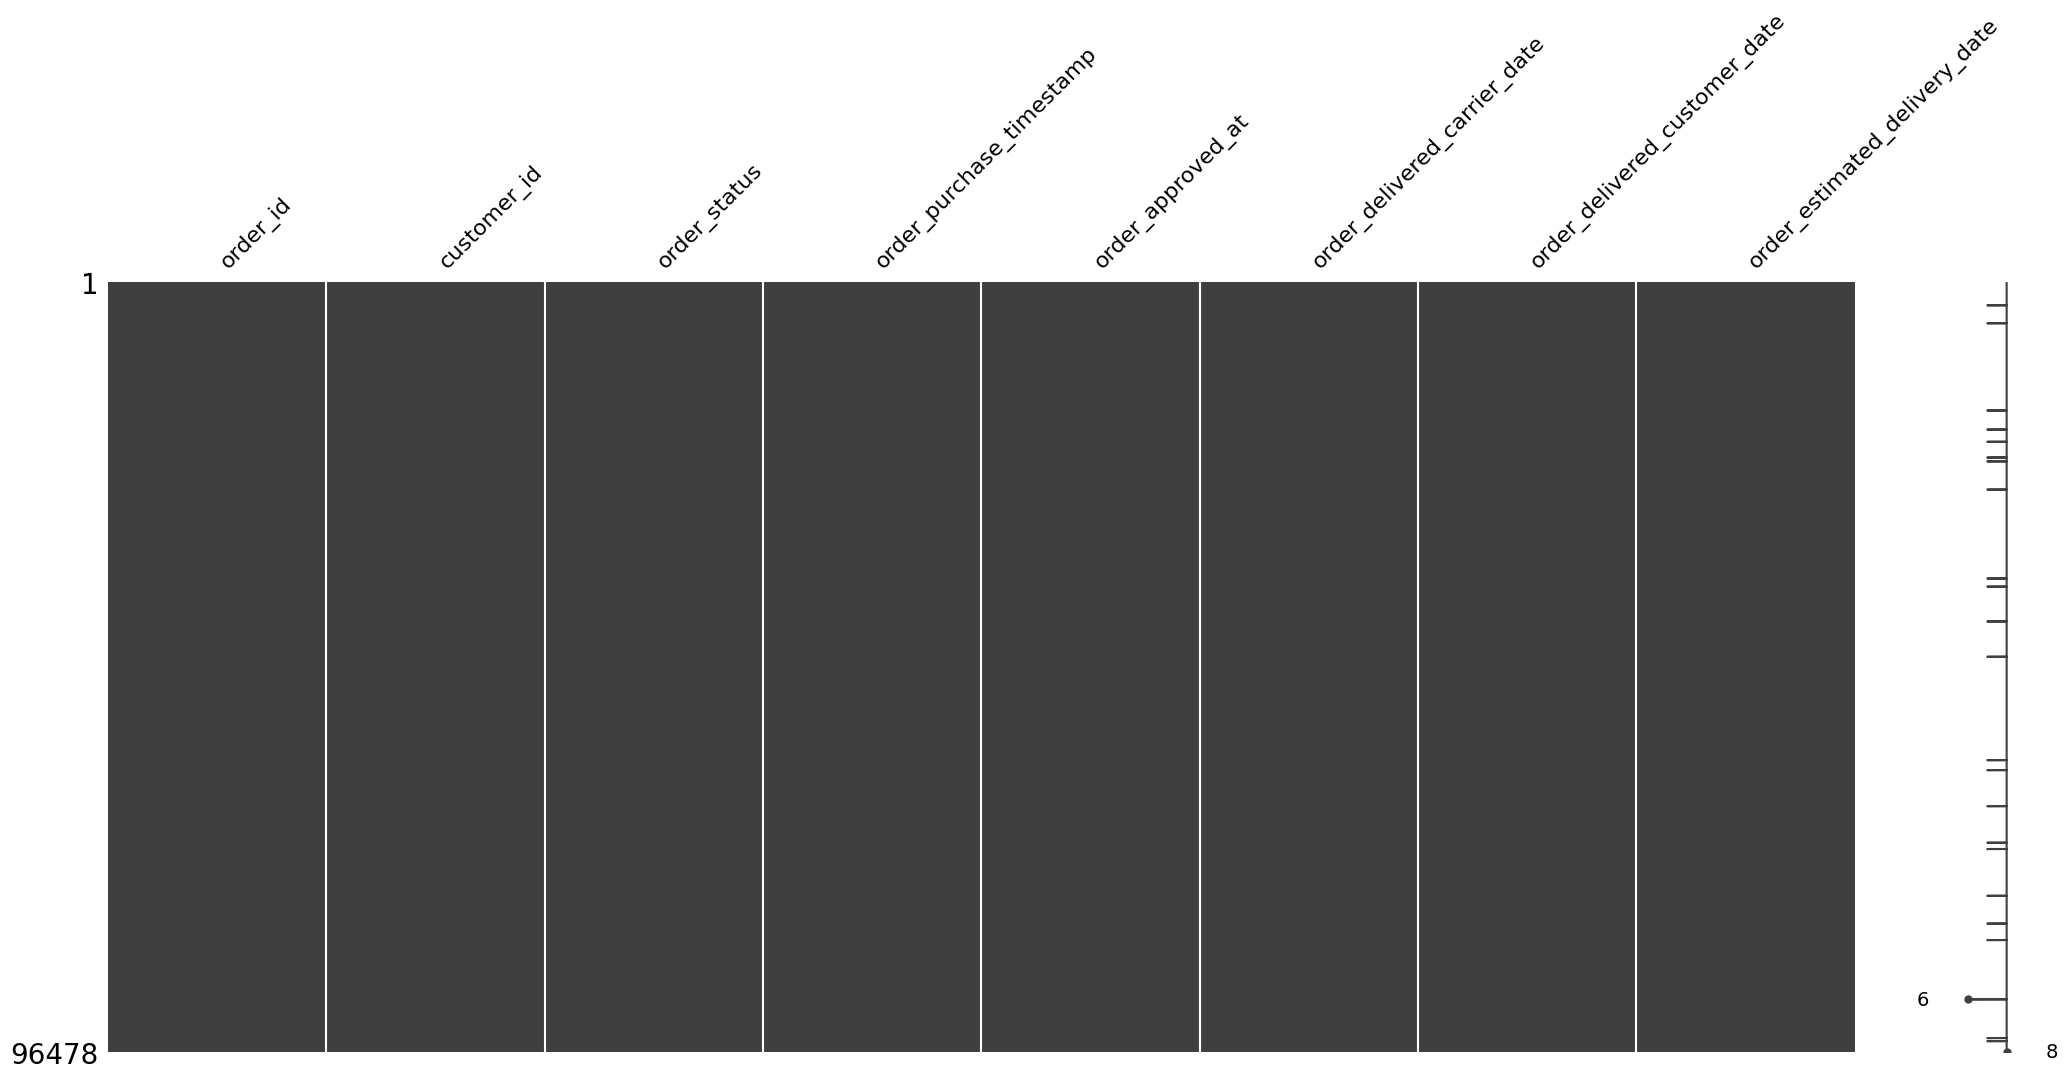

invoiced


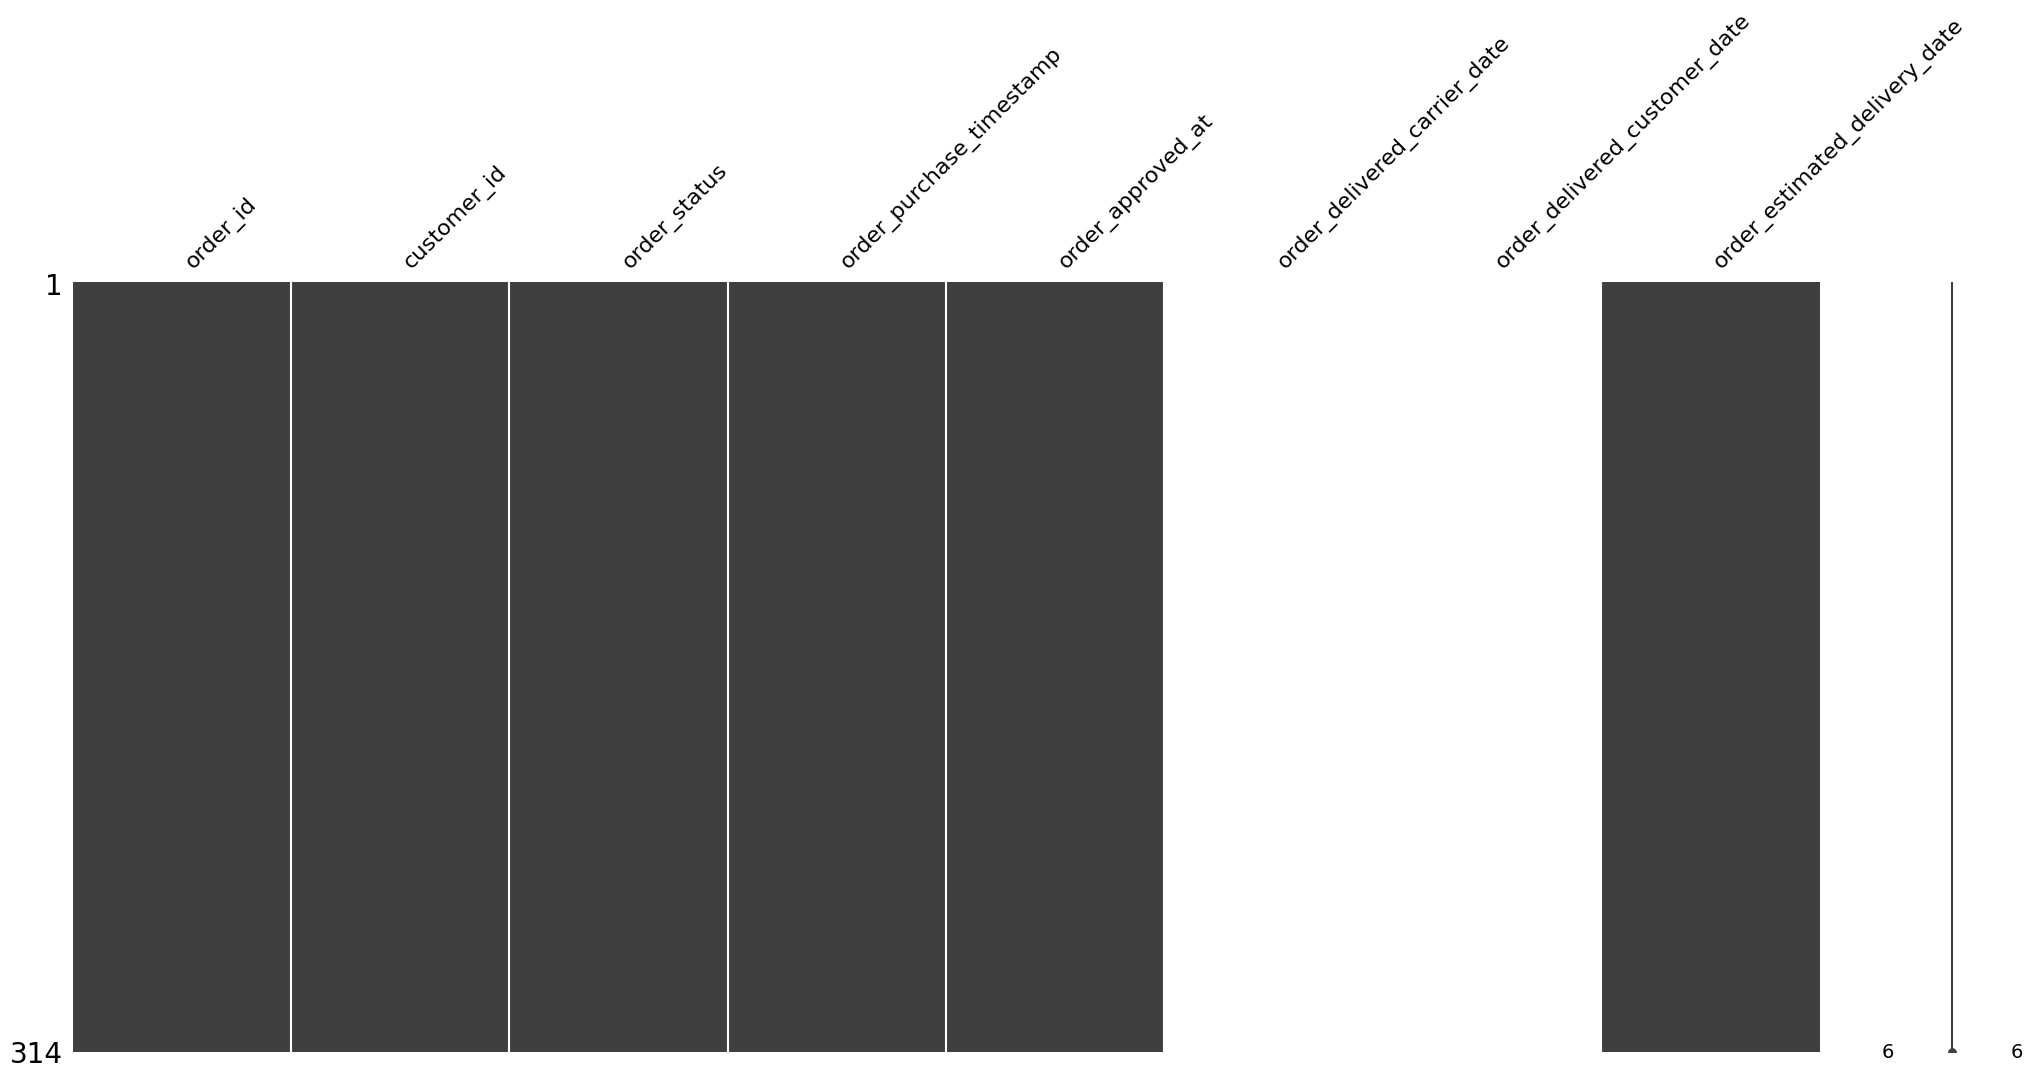

shipped


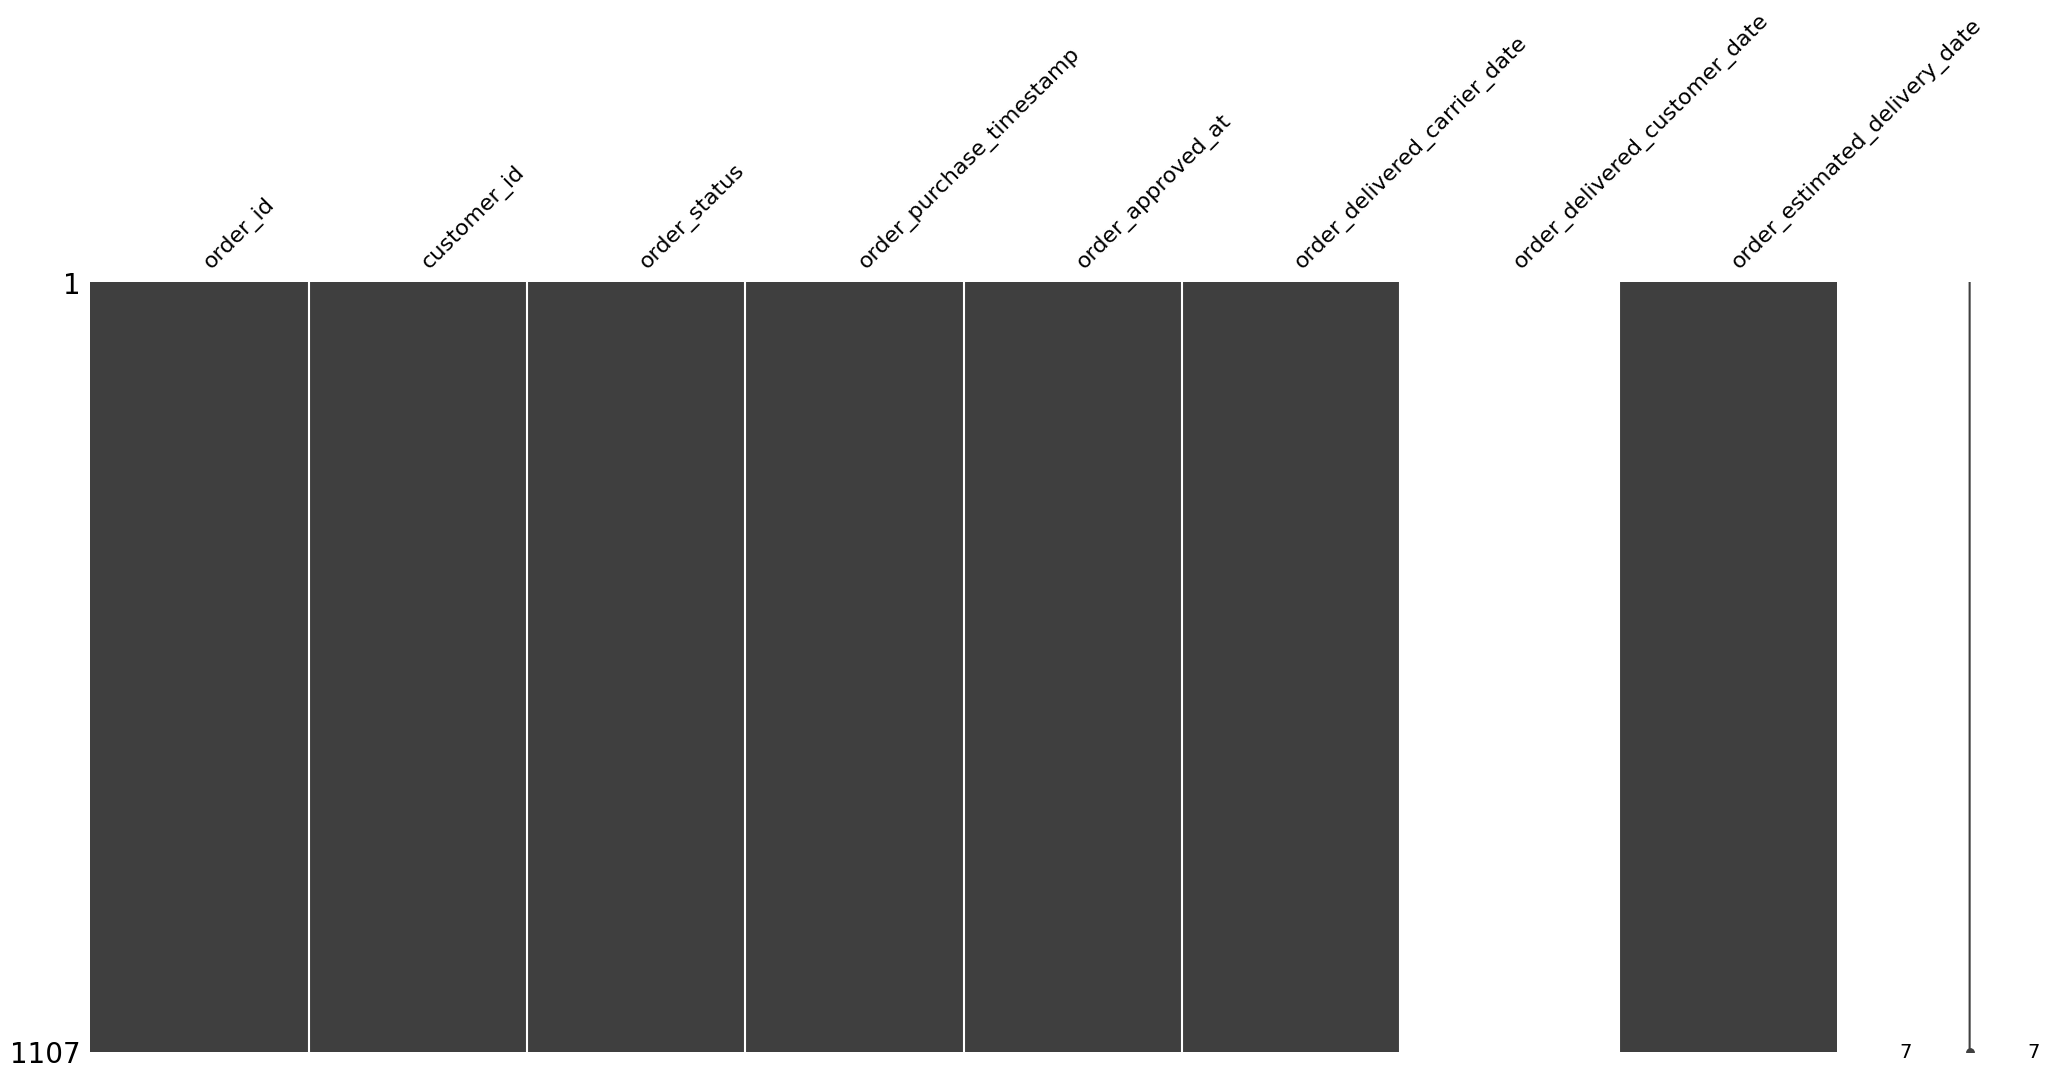

processing


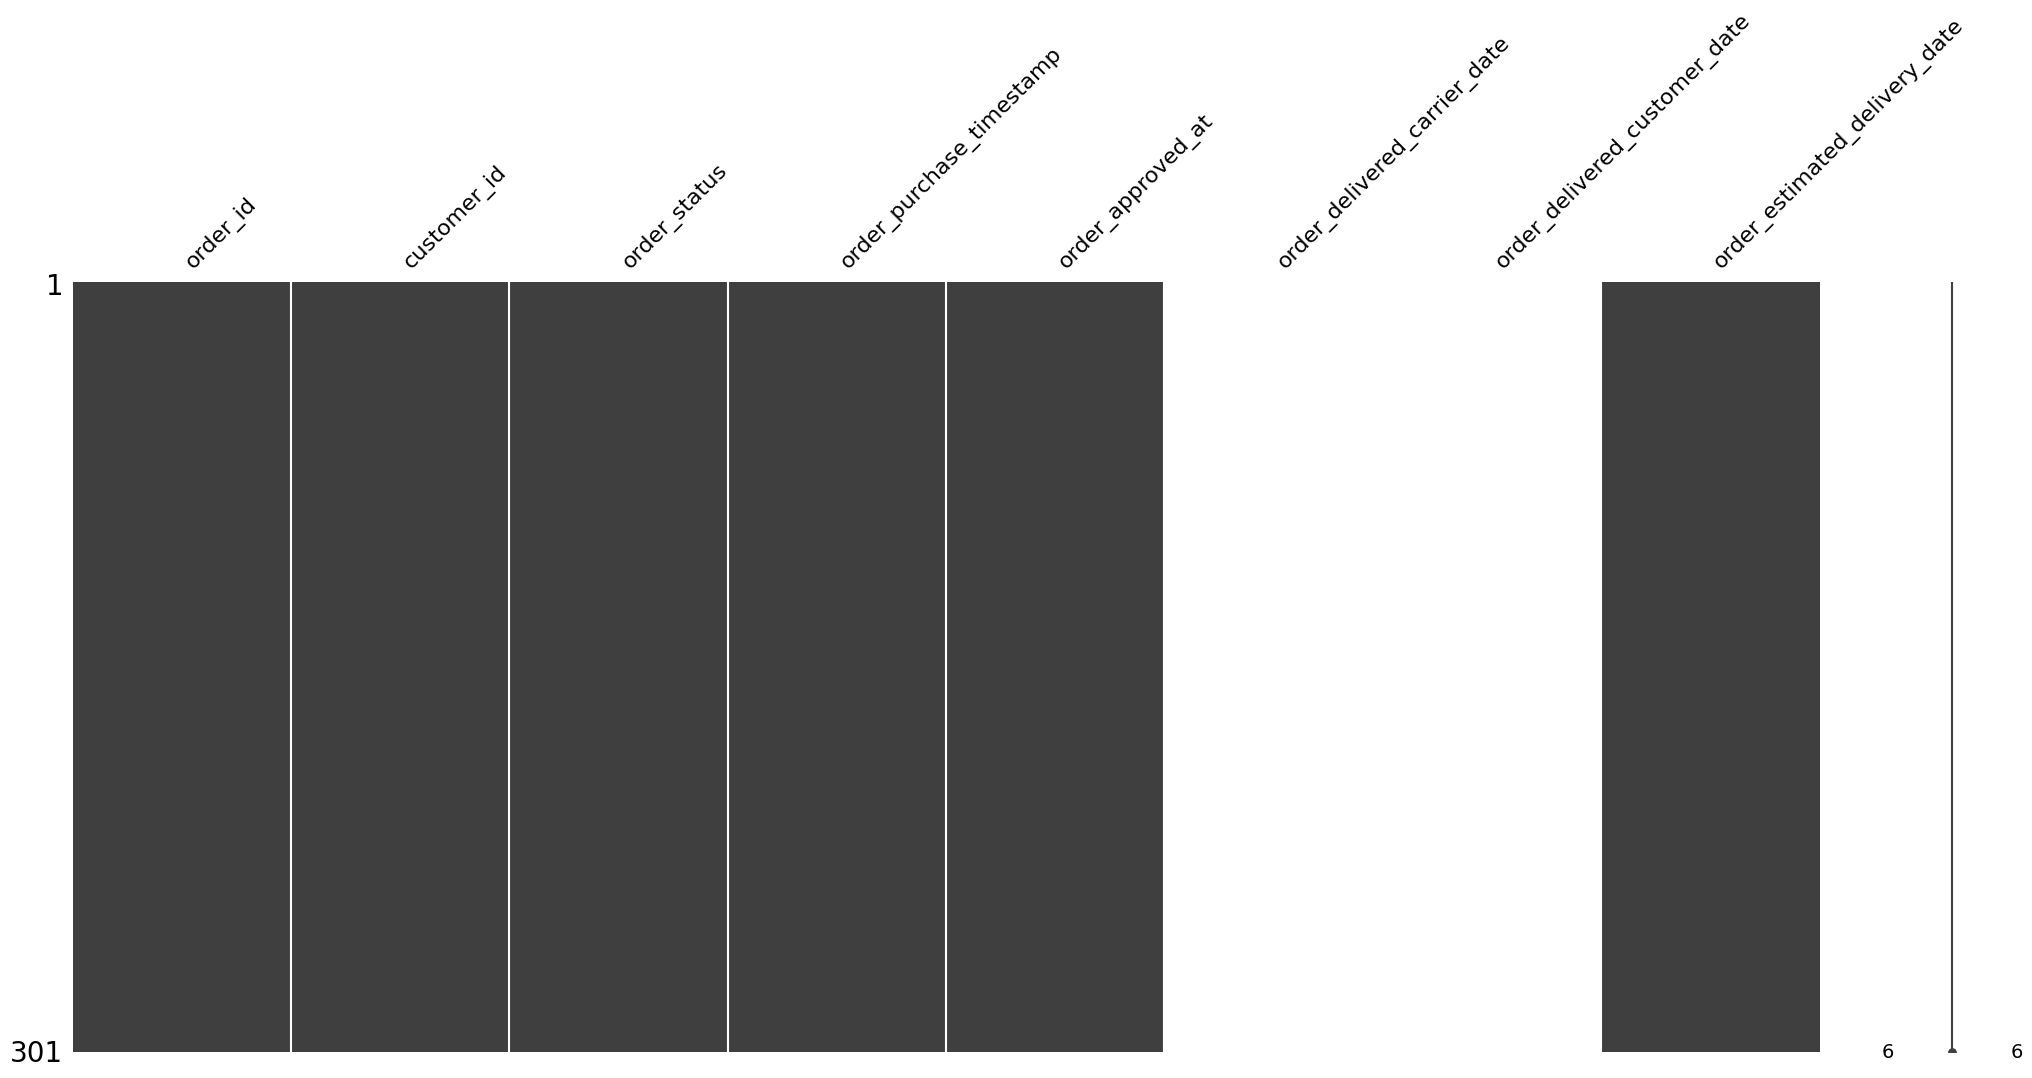

unavailable


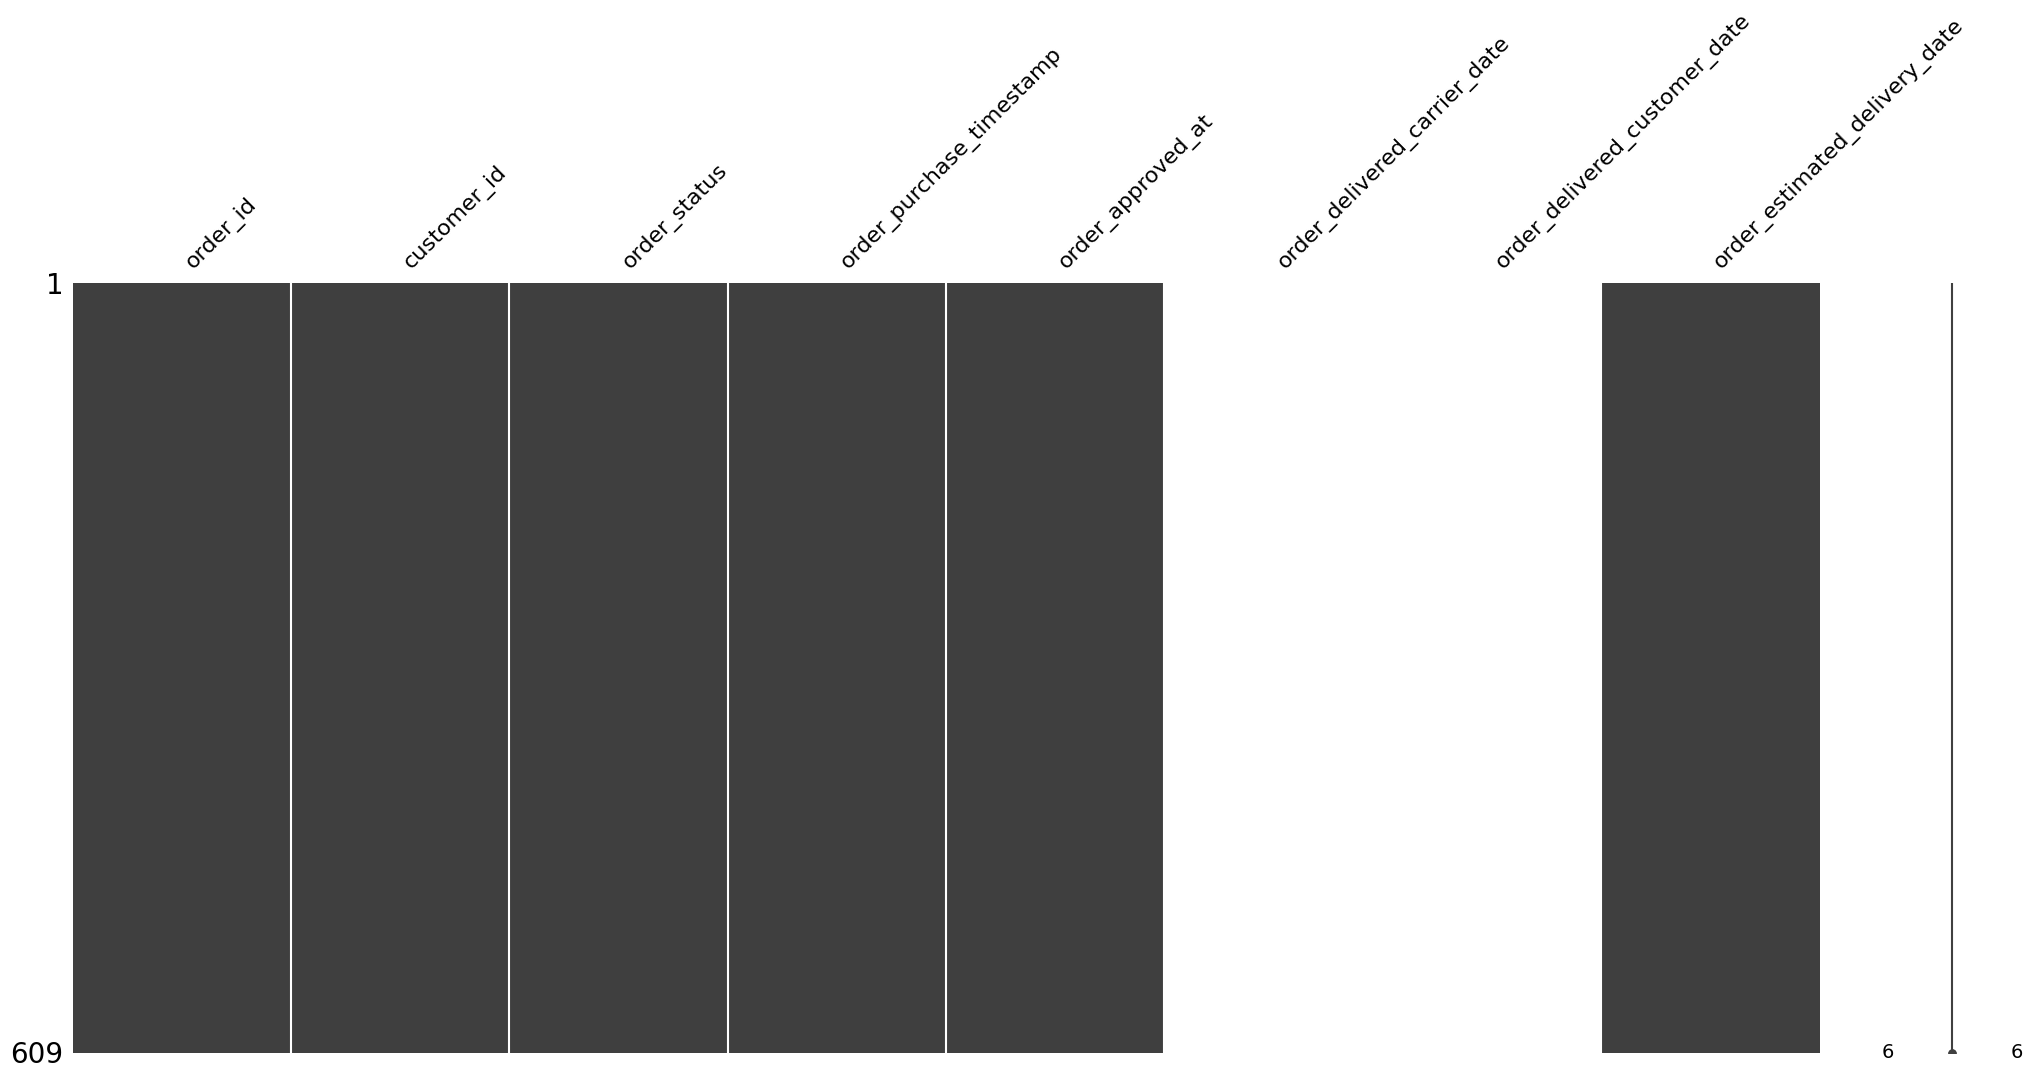

canceled


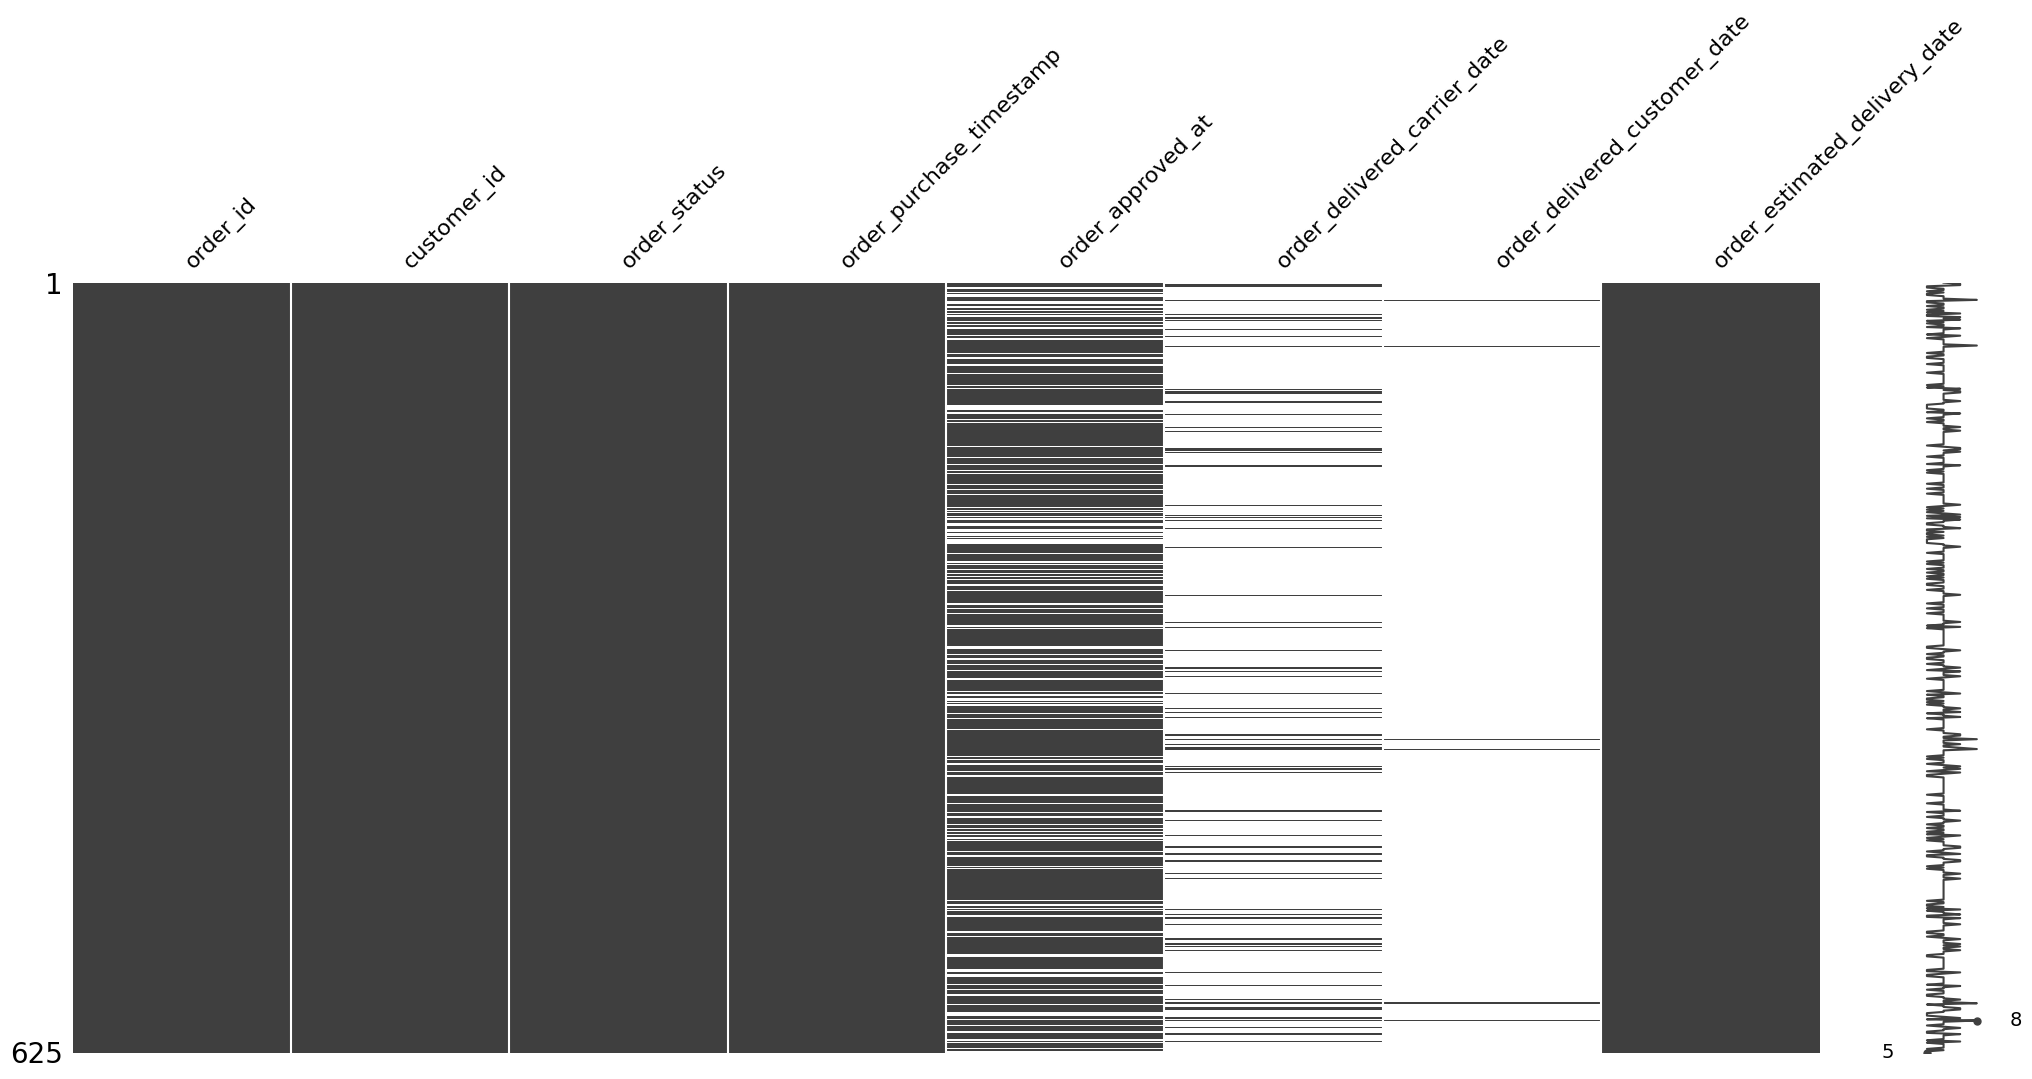

created


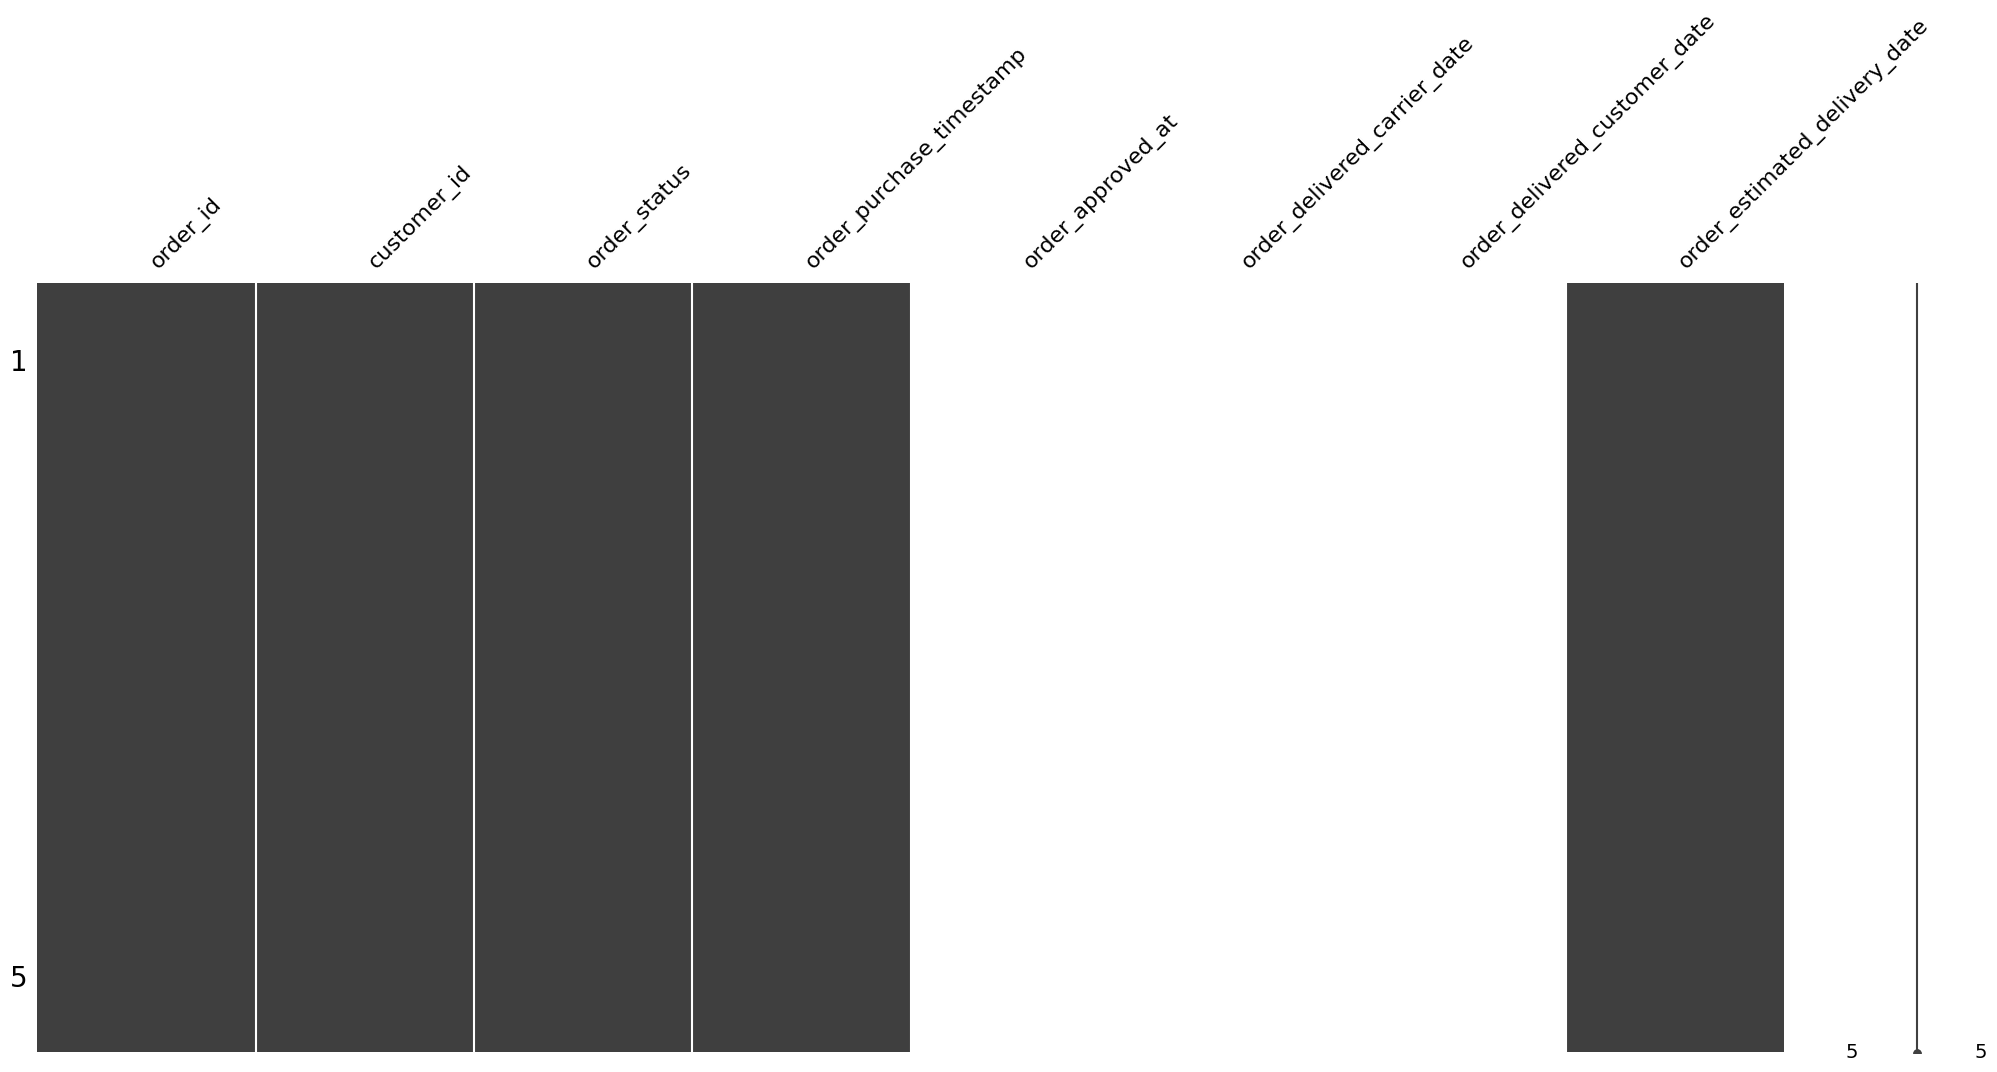

approved


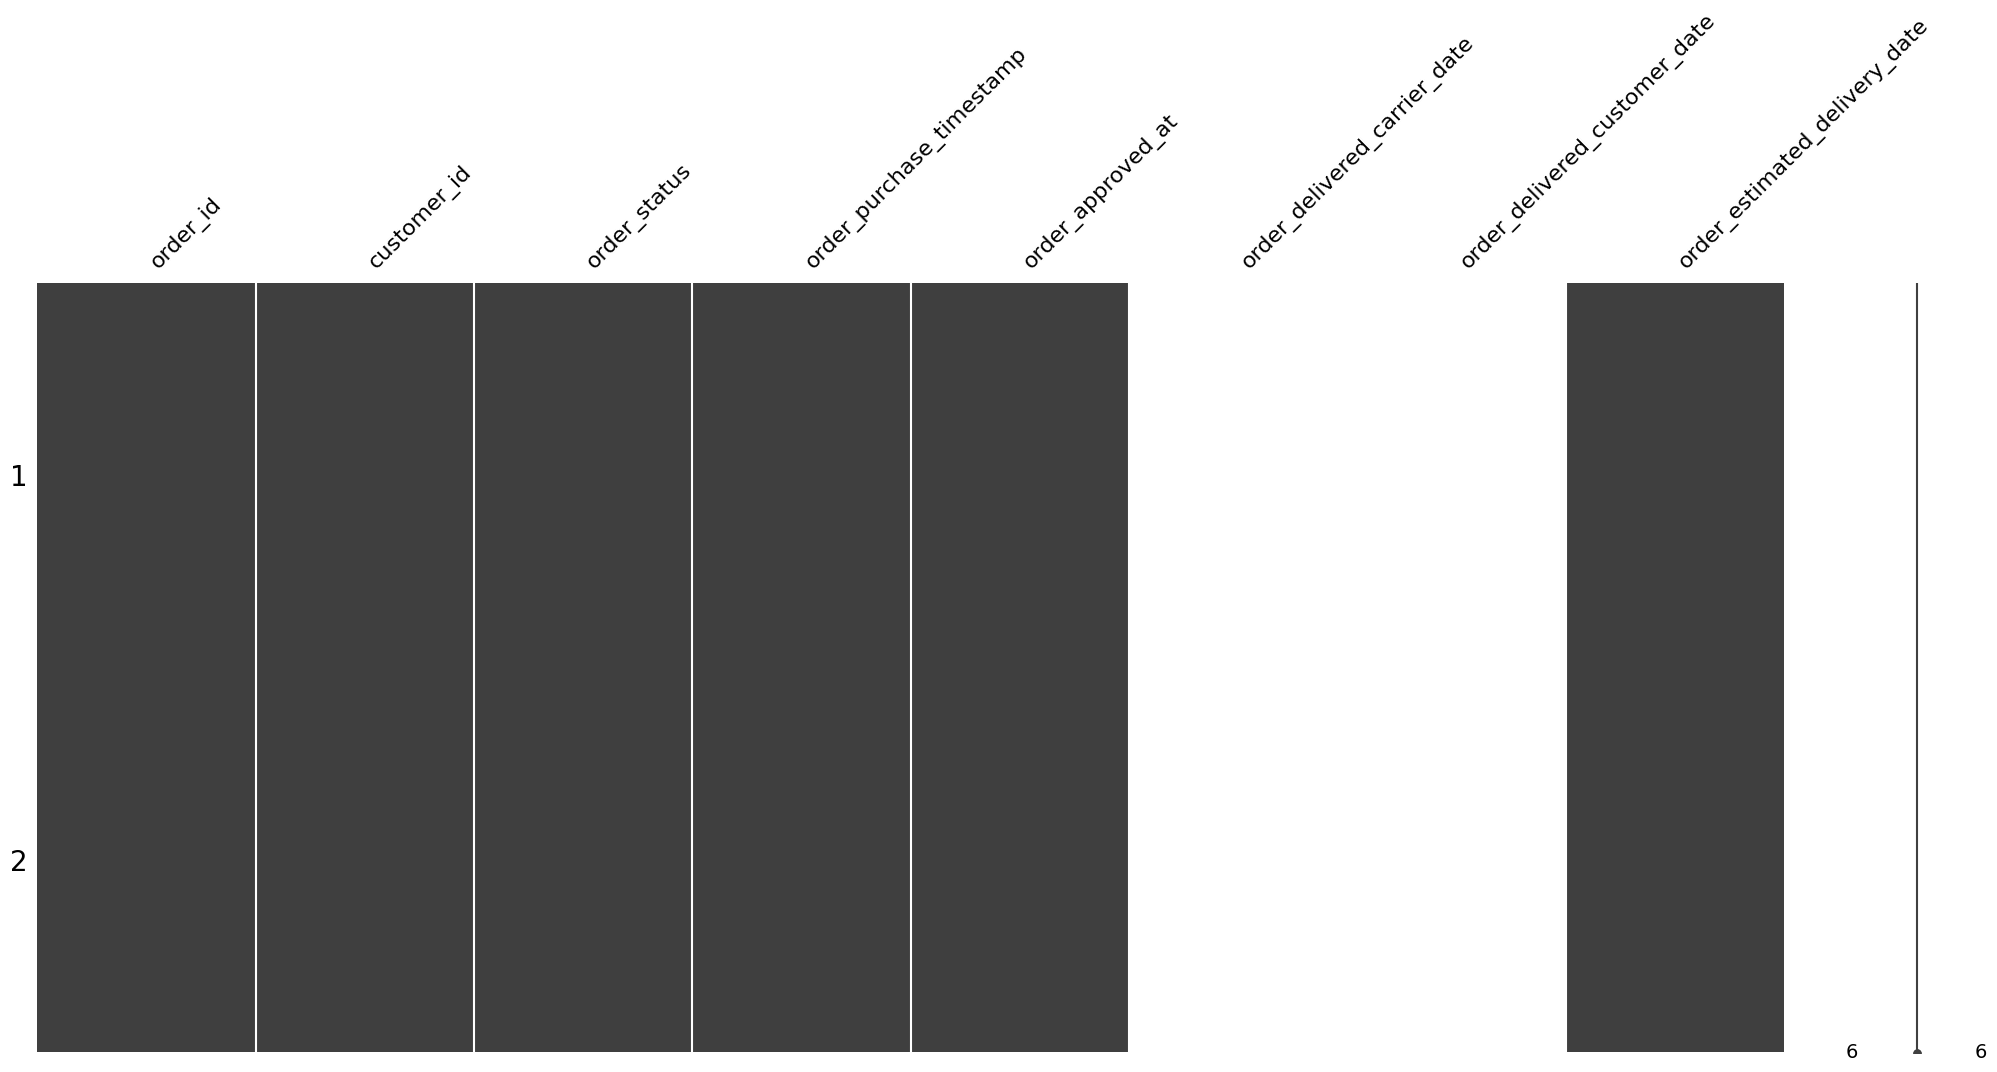

In [145]:
# Observe nulls depending on the status
for status in orders.order_status.unique():
    print(status)
    wdf = orders.query('order_status == @status')
    if len(wdf) > 300:
        wdf.sample(300)
    msno.matrix(wdf)
    plt.show()

We have clear nulls patterns in columns dealing with dates according to the status.

Meaning of these columns thanks to the documentation : 
| Column name    | Description |
| -------- | ------- |
|order_purchase_timestamp | Shows the purchase timestamp|
|order_approved_at | Shows the payment approval timestamp.|
|order_delivered_carrier_date | Shows the order posting timestamp. When it was handled to the logistic partner.|
|order_delivered_customer_date | Shows the actual order delivery date to the customer.|
|order_estimated_delivery_date|Shows the estimated delivery date that was informed to customer at the purchase moment.|

My hypothesis about these status :
- delivered : no nulls --> the product is now at the client's.
- shipped : expected null in the delivery date --> the product is in the hands of the carrier.
- processing : expected nulls (carrier) because the seller is preparing the package.
- unavailable : expected nulls (carrier) the client paid and it was approved but unfortunately the seller cannot send because he does not have any sample left.
- canceled : several reasons --> canceled because not approved, while shipping : was it too long, did it get lost?
*Here, it is somewhat special that the client has a delivered date stamp if the order was canceled.*
Mostly understandable nulls.


- invoiced and approved seem similar. The client paid, and when the seller will notice that, he will start processing the transmission. Expected nulls.
- created : not approved by the bank yet. Expected nulls.

**Conclusion** :
- Every nulls seem legitimate. They are due to the status of the order. 
- However, *some non-null dates* are catching my attention. Why some clients received the package whereas the order was labeled canceled? 

*remark* : As my conclusion are based on sampling, I might want to count nulls in date columns once group by the status to be sure I did not miss anything.


In [146]:
# counting missing dates per order status.
nulls_counts = (orders[["order_approved_at",
                        "order_delivered_carrier_date",
                        "order_delivered_customer_date"]]
                .groupby(orders.order_status)
                .apply(lambda x: x.isnull().sum()))

totals = (orders
          .groupby('order_status')["order_id"]
          .agg(len)
          .rename("total"))

nulls_view = pd.concat([nulls_counts, totals], axis=1)
nulls_view.T.style.background_gradient('Purples')

order_status,approved,canceled,created,delivered,invoiced,processing,shipped,unavailable
order_approved_at,0,141,5,14,0,0,0,0
order_delivered_carrier_date,2,550,5,2,314,301,0,609
order_delivered_customer_date,2,619,5,8,314,301,1107,609
total,2,625,5,96478,314,301,1107,609


In [147]:
# Counting known dates per order status.
not_null_counts = (orders
                   .groupby('order_status')["order_approved_at",
                                            "order_delivered_carrier_date",
                                            "order_delivered_customer_date"]
                   .apply(lambda x: x.notnull().sum()))

totals = (orders
          .groupby('order_status')["order_id"]
          .agg(len)
          .rename("total"))

nulls_view = pd.concat([not_null_counts, totals], axis=1)
nulls_view.T.style.background_gradient('Purples')

/tmp/ipykernel_4554/3517189874.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  not_null_counts = (orders


order_status,approved,canceled,created,delivered,invoiced,processing,shipped,unavailable
order_approved_at,2,484,0,96464,314,301,1107,609
order_delivered_carrier_date,0,75,0,96476,0,0,1107,0
order_delivered_customer_date,0,6,0,96470,0,0,0,0
total,2,625,5,96478,314,301,1107,609


My conclusions were exact except for the delivered status where there are missing dates that should be known.

Or is it possible that the order status is wrong?

Can we know more about that?


In [148]:
mycols = ["order_approved_at",
          "order_delivered_carrier_date",
          "order_delivered_customer_date",
          "order_status"]

delivered = orders.query("order_status =='delivered'")

mask = delivered.loc[:, mycols].isnull().any(axis=1)
display(delivered.loc[mask])

# saving problematic order_ids
problems_order_id = list(delivered.loc[mask].order_id.values)
len(problems_order_id)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22


23

May be crossing this with the reviews would help understand.

Thoughts :
- A package can not be delivered if not given to the carrier at some point. (1 ludicrous case).
- It is possible that the seller was notified of the purchase and sent the package without waiting for the payment approval...

In [149]:
arrived_but_canceled = (orders
                        .loc[orders.order_delivered_customer_date.notnull()]
                        .query("order_status == 'canceled'"))

display(arrived_but_canceled)

# saving more problematic order_ids
problems_order_id.extend(list(arrived_but_canceled.order_id.values))
len(problems_order_id)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


29

### 1.6.4.  [&#9650;](#toc0_) <a id='toc1_6_4_'></a>Not delivered orders and dates

In [150]:
not_delivered = (orders.loc[orders.order_status != 'delivered', :])
display(not_delivered.head())
not_delivered.order_status.value_counts()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
delivered         0
Name: order_status, dtype: int64

In [151]:
statuses = (not_delivered
            .loc[:, ['order_status', 'order_purchase_timestamp', 'order_id']]
            .set_index('order_purchase_timestamp'))

statuses.head()

,order_status,order_id
order_purchase_timestamp,,
2017-04-11 12:22:08,invoiced,136cce7faa42fdb2cefd53fdc79a6098
2018-06-04 16:44:48,shipped,ee64d42b8cf066f35eac1cf57de1aa85
2018-08-03 17:44:42,invoiced,0760a852e4e9d89eb77bf631eaaf1c84
2017-09-03 14:22:03,processing,15bed8e2fec7fdbadb186b57c46c92f2
2018-01-10 11:33:07,shipped,6942b8da583c2f9957e990d028607019


In [152]:
statuses['year'] = statuses.index.year
statuses['week'] = statuses.index.isocalendar().week

In [153]:
statuses.head()

,order_status,order_id,year,week
order_purchase_timestamp,,,,
2017-04-11 12:22:08,invoiced,136cce7faa42fdb2cefd53fdc79a6098,2017,15
2018-06-04 16:44:48,shipped,ee64d42b8cf066f35eac1cf57de1aa85,2018,23
2018-08-03 17:44:42,invoiced,0760a852e4e9d89eb77bf631eaaf1c84,2018,31
2017-09-03 14:22:03,processing,15bed8e2fec7fdbadb186b57c46c92f2,2017,35
2018-01-10 11:33:07,shipped,6942b8da583c2f9957e990d028607019,2018,2


/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/louberehc/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dt

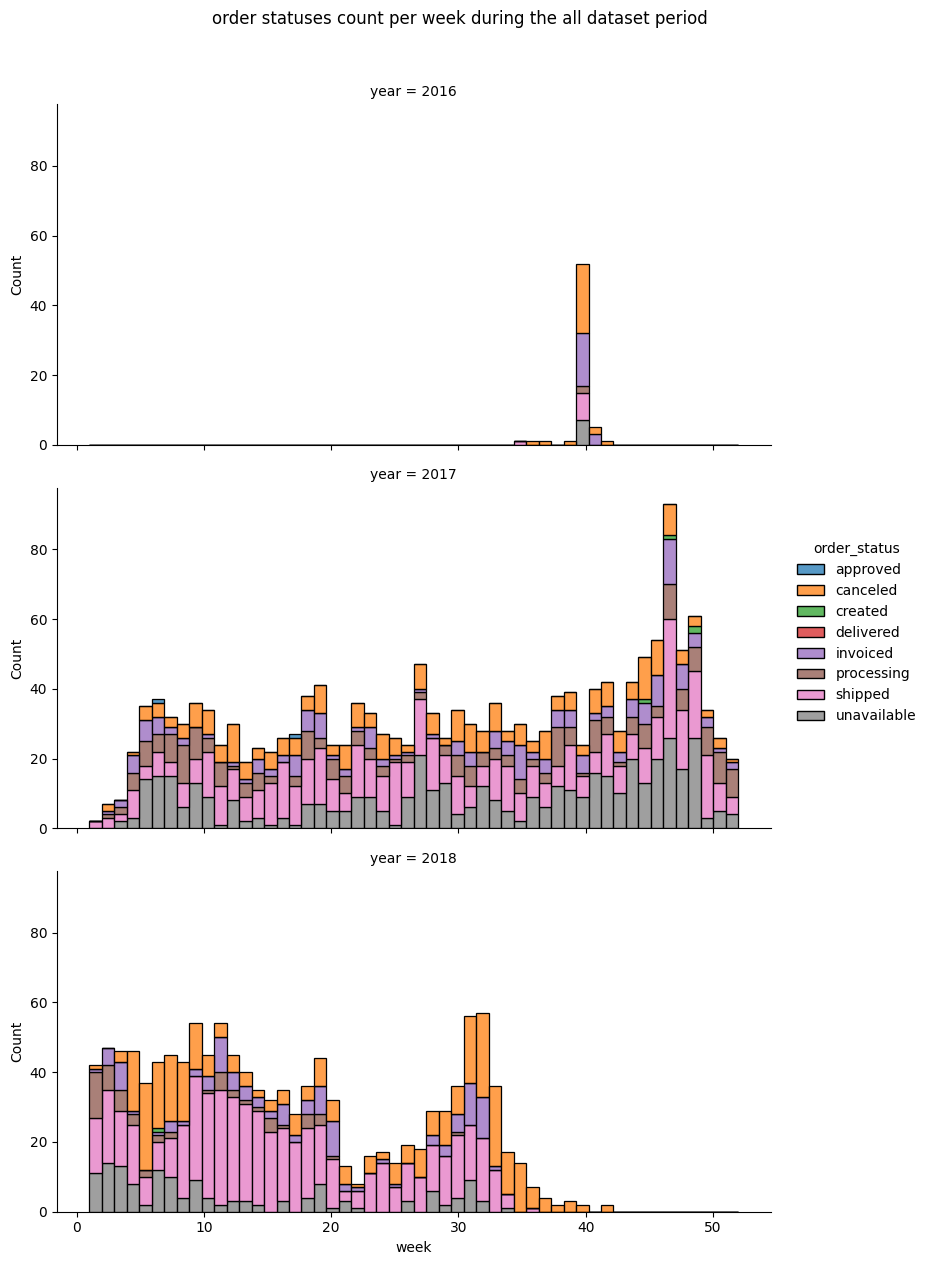

In [154]:
sns.displot(data=statuses, x="week", hue="order_status",
            row="year", multiple="stack", height=4, aspect=2, bins=52)
plt.suptitle('order statuses count per week during the all dataset period',
             y=1.05)
plt.show()

In [155]:
orders.order_purchase_timestamp.max().week

42

I was expecting to essentially see shipped orders in the last weeks of this dataset.
It is very surprising to see there are almost none...

### 1.6.5.  [&#9650;](#toc0_) <a id='toc1_6_5_'></a>Items with no category

In [156]:
no_product_category = products.query("product_category_name.isnull()")
no_product_category.head()

,product_id,product_category_name
105,a41e356c76fab66334f36de622ecbd3a,NaN
128,d8dee61c2034d6d075997acef1870e9b,NaN
145,56139431d72cd51f19eb9f7dae4d1617,NaN
154,46b48281eb6d663ced748f324108c733,NaN
197,5fb61f482620cb672f5e586bb132eae9,NaN


Need to merge the info to investigate...

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Merging the datasets step by step.

The idea of merging the information is to build a dataset in which each row would represent the information associated with each product ordered on the platform.

Then, this will allow to group information by client and generate features to characterize it, such as the features used in the RFM approach : 
- Recency ;
- Frequency ;
- Monetary value. 

Let's figure out if there is non-unique id's to better understand how the merging will work according to the following schema.

<img src="./data_schema.png" width="600"/>

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>merging id's

In [157]:
ids = dict(customers="customer_id",
           orders="order_id",
           order_reviews="order_id",
           order_payments="order_id",
           order_items="order_id",
           products="product_id")

for df_name in ids:
    print(df_name)
    data = eval(df_name)
    print('length of the dataframe :')
    print(len(data))
    print('number of unique ids used to merge :')
    print(data[ids[df_name]].nunique())
    print('-'*30)
    

customers
length of the dataframe :
99441
number of unique ids used to merge :
99441
------------------------------
orders
length of the dataframe :
99441
number of unique ids used to merge :
99441
------------------------------
order_reviews
length of the dataframe :
99224
number of unique ids used to merge :
98673
------------------------------
order_payments
length of the dataframe :
103886
number of unique ids used to merge :
99440
------------------------------
order_items
length of the dataframe :
112650
number of unique ids used to merge :
98666
------------------------------
products
length of the dataframe :
32951
number of unique ids used to merge :
32951
------------------------------


First, we can note that all numbers of unique ids are lower than the number of customers from which I am going to start the merging process. Thus, there won't always be a match.

We are expecting 2 one-to-one matches (when the number of unique ids is the same than the dataframe length), but for the rest, some null values will be introduced. We will have to understand why and where there is some missing information and address it.

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Merged_df : customers <-- orders

In [158]:
df = pt.merge_and_display(customers, orders, on="customer_id")

shape before merging : (99441, 5)
shape of the right df: (99441, 8)
shape after merging : (99441, 12)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998391
order_delivered_carrier_date     0.982070
order_delivered_customer_date    0.970183
order_estimated_delivery_date    1.000000
dtype: float64

Null dates already studied.

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Merged_df <-- order_items

In [159]:
df = pt.merge_and_display(df, order_items, on="order_id")

shape before merging : (99441, 12)
shape of the right df: (112650, 7)
shape after merging : (113425, 18)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998581
order_delivered_carrier_date     0.982649
order_delivered_customer_date    0.971532
order_estimated_delivery_date    1.000000
order_item_id                    0.993167
product_id                       0.993167
seller_id                        0.993167
shipping_limit_date              0.993167
price                            0.993167
freight_value                    0.993167
dtype: float64

The last merging is not a one-to-one.

There are orders where no information was matched, resulting in nulls being introduced.
(consistent because we found out the number of unique order_id in the order_items dataframe to be lower than the number of orders.)

Let's try to understand which are the rows impacted.

In [160]:
# Some order had no item correspondance
113425-112650

775

In [161]:
# Checking for the introduced nulls
no_items = df.loc[df[df.columns[-6:]].isnull().any(axis=1), :]
print(no_items.shape)
display(no_items.sample(20))
no_items.order_status.value_counts()

(775, 18)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
95288,758e7d0e5f61d4150e1a47079f601a29,a20b89a4159ced7cda2525202c2eb5c2,6310,carapicuiba,SP,8ae36ddb0c9660dabf5341488efb2a30,unavailable,2018-03-03 12:02:45,2018-03-03 12:15:39,NaT,NaT,2018-03-15,NaN,NaN,NaN,NaN,NaN,NaN
86095,be9e16f7c118e7f49f6399f01fb4a48c,2fe568d05684fa1b16d752caa920afb9,71925,brasilia,DF,309688f286ca9fb39735664ba1e37b29,unavailable,2017-11-26 22:38:45,2017-11-28 03:19:58,NaT,NaT,2017-12-18,NaN,NaN,NaN,NaN,NaN,NaN
42661,4349d17c2c020f08d09713ae2418b119,282612d97acdd764b6e12ea19a426eaf,28990,saquarema,RJ,51b00c5a9b0224f467f74d55424b4235,unavailable,2017-07-09 11:20:12,2017-07-09 11:30:17,NaT,NaT,2017-08-03,NaN,NaN,NaN,NaN,NaN,NaN
57651,c7da870eb04374fc25d71501117ab5f6,31eee58232681b6700ccd39fd5b5f5ed,13417,piracicaba,SP,2867faaa7a912bbc2bf8d8e40d7a0354,unavailable,2017-01-22 20:43:58,2017-01-22 20:55:10,NaT,NaT,2017-03-02,NaN,NaN,NaN,NaN,NaN,NaN
12949,e897805b8661b837d4f0ec8dc77106f2,ee1f5271e9485b974a603453a9df1fac,98015,cruz alta,RS,e9e56ab7d8e993bda2988ed430524126,unavailable,2017-03-05 19:52:00,2017-03-05 20:05:18,NaT,NaT,2017-04-04,NaN,NaN,NaN,NaN,NaN,NaN
43289,efe2a8ee5f67ebcbcc236b53ad3f4282,fa281beca8858479ddf9d567474173aa,9111,santo andre,SP,43c8d05a1478e794217ad3b39398022a,unavailable,2017-08-14 21:10:05,2017-08-14 22:05:23,NaT,NaT,2017-08-25,NaN,NaN,NaN,NaN,NaN,NaN
16897,b070b95287678d11201661cbff914baf,7fd5c42cfb53d4a0fc29e6e121149014,9121,santo andre,SP,9c77f06d1dbb94007e708e9aba680a03,unavailable,2018-02-10 16:00:05,2018-02-10 16:10:24,NaT,NaT,2018-02-26,NaN,NaN,NaN,NaN,NaN,NaN
9721,cca8b12b9e669afd8a28ff57fd5c5e75,331a638bfc01a1382d0ecb0079d8807f,32015,contagem,MG,f2a335c81aebf64a9a4309436e7af4a8,unavailable,2017-06-05 17:16:12,2017-06-05 17:30:06,NaT,NaT,2017-06-28,NaN,NaN,NaN,NaN,NaN,NaN
70168,001574cd5824c0b1ea90dd4f4ba6d5b8,8141dd1e051afe7d72079570fe72d5f1,8248,sao paulo,SP,ccac33950ffc27cb905dbcdfb099494a,unavailable,2017-11-26 02:13:57,2017-11-26 02:30:13,NaT,NaT,2017-12-19,NaN,NaN,NaN,NaN,NaN,NaN
21822,f0f1d8de8ddaad572cef4b07bdf94d6d,17a4a1b241b0579faae76c9a3bbb29c4,86290,rancho alegre,PR,5ca9d935dd5306bf85a2f1e263d058f1,unavailable,2018-02-06 16:31:59,2018-02-06 16:51:46,NaT,NaT,2018-03-08,NaN,NaN,NaN,NaN,NaN,NaN


unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
approved         0
delivered        0
processing       0
Name: order_status, dtype: int64

It seems reasonable that unavailable orders have no items correspondance. It is also possible that for unavailable reasons, someone canceled and thus changed the order status. 

But invoiced and shipped orders should at least had one item. And what about created?

In [162]:
instruction = ds.or_query_instruction('order_status',
                                      ["created", "invoiced", "shipped"])

problematic_no_items = no_items.query(instruction)
problematic_no_items

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
14902,4ee64f4bfc542546f422da0aeb462853,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN
51673,7d61b9f4f216052ba664f22e9c504ef1,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,90ab3e7d52544ec7bc3363c82689965f,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN
58265,964a6df3d9bdf60fe3e7b8bb69ed893a,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,dba5062fbda3af4fb6c33b1e040ca38f,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN
62064,d7bed5fac093a4136216072abaf599d5,f15a952dfc52308d0361288fbf42c7b3,91250,porto alegre,RS,a68ce1686d536ca72bd2dadc4b8671e5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01,NaN,NaN,NaN,NaN,NaN,NaN
77472,b2d7ae0415dbbca535b5f7b38056dd1f,6a2da481aa7827b951175772a0fe8bb8,16012,aracatuba,SP,2ce9683175cdab7d1c95bcbb3e36f478,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,NaN,NaN,NaN,NaN,NaN,NaN
87946,0d00d77134cae4c58695086ad8d85100,8886115442775dd8a20c2dcc921c7cc8,88070,florianopolis,SC,e04f1da1f48bf2bbffcf57b9824f76e1,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,NaN,NaN,NaN,NaN,NaN,NaN
90395,438449d4af8980d107bf04571413a8e7,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,b5359909123fa03c50bdb0cfed07f098,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,NaN,NaN,NaN,NaN,NaN,NaN
99547,725e9c75605414b21fd8c8d5a1c2f1d6,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,7a4df5d8cff4090e541401a20a22bb80,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4.  [&#9650;](#toc0_) <a id='toc2_4_'></a> merged_df <-- order_payments

In [163]:
df  = pt.merge_and_display(df, order_payments, on="order_id")

shape before merging : (113425, 18)
shape of the right df: (103886, 5)
shape after merging : (118434, 22)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982488
order_delivered_customer_date    0.971317
order_estimated_delivery_date    1.000000
order_item_id                    0.992992
product_id                       0.992992
seller_id                        0.992992
shipping_limit_date              0.992992
price                            0.992992
freight_value                    0.992992
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
dtype: float64

Here the number of rows grows too.
Let's investigate why

In [164]:
# Searching for order_id which somehow got expanded
(df.groupby('order_id')["customer_id"].agg(len)
 .sort_values(ascending=False)
 .rename("order_id_number_of_rows")
 .head())

order_id
895ab968e7bb0d5659d16cd74cd1650c    63
fedcd9f7ccdc8cba3a18defedd1a5547    38
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
c6492b842ac190db807c15aff21a7dd6    24
Name: order_id_number_of_rows, dtype: int64

In [165]:
# What about the order_id with the most rows.
(df.query("order_id == '895ab968e7bb0d5659d16cd74cd1650c'")
   .sort_values(['order_item_id', 'payment_sequential']))

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
22290,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,1.0,voucher,1.0,2.61
22296,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,2.0,voucher,1.0,2.61
22301,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,3.0,voucher,1.0,2.61
22294,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,4.0,voucher,1.0,2.61
22302,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,5.0,voucher,1.0,2.61
22309,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,6.0,voucher,1.0,2.61
22304,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,7.0,voucher,1.0,2.60
22299,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,8.0,voucher,1.0,0.41
22308,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,9.0,voucher,1.0,2.61
22303,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,10.0,voucher,1.0,16.70


This order has 3 items and was paid with small vouchers.
One line per voucher was introduced.

In [166]:
# What about the second order_id with the most rows.
(df.query("order_id == 'fedcd9f7ccdc8cba3a18defedd1a5547'")
   .sort_values(['order_item_id', 'payment_sequential']))

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
58396,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,1.0,credit_card,1.0,1.67
58401,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,2.0,voucher,1.0,7.76
58411,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,3.0,voucher,1.0,26.94
58406,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,4.0,voucher,1.0,10.33
58404,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,5.0,voucher,1.0,9.76
58413,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,6.0,voucher,1.0,8.60
58412,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,7.0,voucher,1.0,11.78
58399,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,8.0,voucher,1.0,31.43
58397,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,9.0,voucher,1.0,5.30
58405,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,10.0,voucher,1.0,13.27


It is the same thing but the client also paid a little part with its credit card.

In [167]:
df.loc[df[df.columns[-4:]].isnull().any(axis=1)]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
25207,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,NaN,NaN,NaN,NaN
25208,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,NaN,NaN,NaN,NaN
25209,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,NaN,NaN,NaN,NaN


Here we have missing information...

In [168]:
rcols = ["order_id",
         'price',
         'freight_value',
         'payment_value',
         "payment_sequential",
         "payment_installments",
         "order_item_id"]
grouped2 = (df.groupby(["order_id"], sort=False)[rcols])

In [169]:
order_multiple_lines = grouped2.filter(lambda x: len(x)>1)

In [170]:
grouped3 = order_multiple_lines.groupby('order_id', sort=False)

In [171]:
# Visualize the 5 first groups.
for n, key in enumerate(grouped3.groups.keys()):
    display(grouped3.get_group(key))
    if n>=5:
        break

,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
18,17825f24877a9289214c301ae0c9424b,89.9,12.13,34.05,2.0,1.0,1.0
19,17825f24877a9289214c301ae0c9424b,89.9,12.13,67.98,1.0,1.0,1.0


,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
22,aaff8afa47c8426e414a6d908a97713c,59.9,17.67,232.71,1.0,2.0,1.0
23,aaff8afa47c8426e414a6d908a97713c,59.9,17.67,232.71,1.0,2.0,2.0
24,aaff8afa47c8426e414a6d908a97713c,59.9,17.67,232.71,1.0,2.0,3.0


,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
36,77b062be7c5bd21712905feb8e1cfeed,56.99,16.13,134.25,1.0,8.0,1.0
37,77b062be7c5bd21712905feb8e1cfeed,44.99,16.14,134.25,1.0,8.0,2.0


,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
38,a9119eb77d6200811953803a7b6539e1,30.5,15.23,44.92,2.0,1.0,1.0
39,a9119eb77d6200811953803a7b6539e1,30.5,15.23,0.81,1.0,1.0,1.0


,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
50,14282bc70be9bdda515182fb1ce62af4,11.99,13.47,50.92,1.0,1.0,1.0
51,14282bc70be9bdda515182fb1ce62af4,11.99,13.47,50.92,1.0,1.0,2.0


,order_id,price,freight_value,payment_value,payment_sequential,payment_installments,order_item_id
60,a6917b5d71e0e9bc434e9228db8daeb2,788.42,21.28,499.72,2.0,1.0,1.0
61,a6917b5d71e0e9bc434e9228db8daeb2,788.42,21.28,309.98,1.0,1.0,1.0


An order with multiple lines can have its lines extended because there is multiple items and/or multiple sequential payments.

## 2.5.  [&#9650;](#toc0_) <a id='toc2_5_'></a>Checking wether the order total amount is equal to the payment made by the client.

Let's pick up 3 complex situations to confirm we understood how to calculate the total price of the order, and the total payment made by the client.

In [172]:
the_order_id = "a9119eb77d6200811953803a7b6539e1"
ex1 = (orders
 .query('order_id == @the_order_id')
.merge(order_payments.query('order_id == @the_order_id'))
.merge(order_items.query('order_id == @the_order_id')))
ex1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,a9119eb77d6200811953803a7b6539e1,469634941c27cd844170935a3cf60b95,delivered,2018-03-12 13:07:03,2018-03-12 13:15:28,2018-03-13 22:12:18,2018-03-22 18:28:55,2018-03-29,2,voucher,1,44.92,1,aa280035c50ba62c746480a59045eec4,fa40cc5b934574b62717c68f3d678b6d,2018-03-16 13:15:28,30.5,15.23
1,a9119eb77d6200811953803a7b6539e1,469634941c27cd844170935a3cf60b95,delivered,2018-03-12 13:07:03,2018-03-12 13:15:28,2018-03-13 22:12:18,2018-03-22 18:28:55,2018-03-29,1,credit_card,1,0.81,1,aa280035c50ba62c746480a59045eec4,fa40cc5b934574b62717c68f3d678b6d,2018-03-16 13:15:28,30.5,15.23


In [173]:
ex2 = (orders
 .query('order_id == "aaff8afa47c8426e414a6d908a97713c"')
.merge(order_payments.query('order_id == "aaff8afa47c8426e414a6d908a97713c"'))
.merge(order_items.query('order_id == "aaff8afa47c8426e414a6d908a97713c"')))
ex2

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,aaff8afa47c8426e414a6d908a97713c,690172ab319622688d3b4df42f676898,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06,1,credit_card,2,232.71,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67
1,aaff8afa47c8426e414a6d908a97713c,690172ab319622688d3b4df42f676898,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06,1,credit_card,2,232.71,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67
2,aaff8afa47c8426e414a6d908a97713c,690172ab319622688d3b4df42f676898,delivered,2017-10-15 11:08:48,2017-10-15 11:25:49,2017-10-16 21:36:29,2017-10-25 22:30:58,2017-11-06,1,credit_card,2,232.71,3,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2017-10-19 11:25:49,59.9,17.67


In [174]:
the_order_id = 'fedcd9f7ccdc8cba3a18defedd1a5547'
ex3 = (orders
       .query('order_id == @the_order_id')
       .merge(order_payments.query('order_id == @the_order_id'))
       .merge(order_items.query('order_id == @the_order_id'))
       )
ex3

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,15,voucher,1,10.66,1,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
1,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,15,voucher,1,10.66,2,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
2,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1,credit_card,1,1.67,1,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
3,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1,credit_card,1,1.67,2,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
4,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,9,voucher,1,5.30,1,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
5,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,9,voucher,1,5.30,2,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
6,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,11,voucher,1,8.42,1,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
7,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,11,voucher,1,8.42,2,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
8,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,8,voucher,1,31.43,1,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88
9,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,8,voucher,1,31.43,2,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88


We see that when merging the payment info, we have more than one row per item sold on the platform if the payment was not done at once. Actually, it becomes a bit tricky to interpret what a row is at that point.

What is important, is to understand how to gather all the information about a client, while being able to recompose what happened around the order without going astray.

For that, I've designed function available in the project_tools.py file.

In [175]:
for gr in [ex1, ex2, ex3]:
    print(f"total price : {pt.order_total_price(gr)}")

total price : 45.73
total price : 232.71
total price : 205.74


In [176]:
for gr in [ex1, ex2, ex3]:
    print(f"total payment: {pt.total_payment_value(gr)}")

total payment: 45.73
total payment: 232.71
total payment: 205.74


Let's now check if all orders meet the condition total price == total payment.

In [177]:
# Compute the total order price (price + freight values)
total_order_cost = (df
                    .groupby('order_id')
                    .apply(pt.order_total_price))

# Map the information to the merged dataframe.
df['total_order_cost'] = df.order_id.map(total_order_cost)

In [178]:
# Compute the sum of all payments.
total_payment = (df
                 .groupby('order_id')
                 .apply(pt.total_payment_value))

df['total_payment_value'] = df.order_id.map(total_payment)

# Compute diff which should be 0
df["cost_minus_payment"] = df.total_order_cost - df.total_payment_value

In [179]:
# Select all inconsistencies : > 0.05 reales
# (possible rounding error of 1 centavo each time)
cost_payment_inconsistency = df.query('abs(cost_minus_payment) >= 0.05')
cost_payment_inconsistency.shape

(1161, 25)

In [181]:
cols = ['order_id', 'order_status', 'price', 'freight_value', 'payment_sequential', 'payment_type',
        'payment_installments', 'payment_value', 'total_order_cost',
        'total_payment_value', 'cost_minus_payment']

cost_payment_inconsistency.sample(20).loc[:, cols]

,order_id,order_status,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment
72580,b2673ed6360dc341a4728dbd632f935b,unavailable,NaN,NaN,1.0,credit_card,1.0,28.13,0.00,28.13,-28.13
101931,df2f177b04bac67798590bc71213dcc2,unavailable,NaN,NaN,1.0,credit_card,1.0,248.94,0.00,248.94,-248.94
5929,2fadef94d26b8d88791d48a31129380d,delivered,44.90,12.79,1.0,credit_card,4.0,61.04,57.69,61.04,-3.35
61870,ddaec6fff982b13e7e048b627a11d6da,canceled,NaN,NaN,1.0,boleto,1.0,116.99,0.00,116.99,-116.99
98687,b3f7e36f7ae979c02959004e9d800387,delivered,49.90,15.56,1.0,credit_card,5.0,70.04,65.46,70.04,-4.58
25571,4324f32177ce15c52c8e1c570c259dc0,delivered,98.99,20.77,1.0,credit_card,12.0,138.31,119.76,138.31,-18.55
113977,b8b3f1a93f6899699c4cfab3f0cb85e0,delivered,89.99,18.87,1.0,credit_card,12.0,125.74,108.86,125.74,-16.88
91928,65959cbdb267c29a5cb0021a367df75c,unavailable,NaN,NaN,1.0,credit_card,1.0,24.52,0.00,24.52,-24.52
42736,0cfc5b8b63bf71f738f96e68adb96b3d,unavailable,NaN,NaN,1.0,boleto,1.0,246.19,0.00,246.19,-246.19
21524,1f4e46205be9ddf4f9b0e98b11a1a570,delivered,79.90,19.53,1.0,credit_card,10.0,112.36,99.43,112.36,-12.93


Observations on the 20 samples:

- When the order has a status such as created, canceled or unavailable, it seems that the price is set to 0 but not the payment value. 
- Otherwise, when there is a difference, I ascertain there are multiple installments. Is the difference linked to fees?

Let's generalize.

### 2.5.1.  [&#9650;](#toc0_) <a id='toc2_5_1_'></a>Total order cost == 0

In [182]:
(cost_payment_inconsistency
 .query('total_order_cost == 0')
 .order_status.value_counts())

unavailable    643
canceled       176
created          5
invoiced         2
shipped          1
approved         0
delivered        0
processing       0
Name: order_status, dtype: int64

It is confirmed, and it seems that we catch the same "outliers than before". 
Let's verify that :

In [183]:
(cost_payment_inconsistency
 .query('total_order_cost == 0')
 .query(ds.or_query_instruction("order_status", ["invoiced",
                                                 "created",
                                                 "shipped"]
                             )
        )
 )

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment
15560,4ee64f4bfc542546f422da0aeb462853,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,7.0,105.87,0.0,105.87,-105.87
53979,7d61b9f4f216052ba664f22e9c504ef1,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,90ab3e7d52544ec7bc3363c82689965f,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,6.0,245.85,0.0,245.85,-245.85
60899,964a6df3d9bdf60fe3e7b8bb69ed893a,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,dba5062fbda3af4fb6c33b1e040ca38f,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN,1.0,boleto,1.0,137.60,0.0,137.60,-137.60
64857,d7bed5fac093a4136216072abaf599d5,f15a952dfc52308d0361288fbf42c7b3,91250,porto alegre,RS,a68ce1686d536ca72bd2dadc4b8671e5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01,NaN,NaN,NaN,NaN,NaN,NaN,1.0,boleto,1.0,77.73,0.0,77.73,-77.73
80958,b2d7ae0415dbbca535b5f7b38056dd1f,6a2da481aa7827b951175772a0fe8bb8,16012,aracatuba,SP,2ce9683175cdab7d1c95bcbb3e36f478,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,NaN,NaN,NaN,NaN,NaN,NaN,1.0,boleto,1.0,73.04,0.0,73.04,-73.04
91901,0d00d77134cae4c58695086ad8d85100,8886115442775dd8a20c2dcc921c7cc8,88070,florianopolis,SC,e04f1da1f48bf2bbffcf57b9824f76e1,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,7.0,76.19,0.0,76.19,-76.19
94457,438449d4af8980d107bf04571413a8e7,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,b5359909123fa03c50bdb0cfed07f098,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,NaN,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,10.0,160.94,0.0,160.94,-160.94
104008,725e9c75605414b21fd8c8d5a1c2f1d6,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,7a4df5d8cff4090e541401a20a22bb80,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,NaN,NaN,NaN,NaN,NaN,NaN,1.0,boleto,1.0,37.84,0.0,37.84,-37.84


In [184]:
problematic_no_items

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
14902,4ee64f4bfc542546f422da0aeb462853,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,NaN,NaN,NaN,NaN,NaN,NaN
51673,7d61b9f4f216052ba664f22e9c504ef1,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,90ab3e7d52544ec7bc3363c82689965f,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN
58265,964a6df3d9bdf60fe3e7b8bb69ed893a,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,dba5062fbda3af4fb6c33b1e040ca38f,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,NaN,NaN,NaN,NaN,NaN,NaN
62064,d7bed5fac093a4136216072abaf599d5,f15a952dfc52308d0361288fbf42c7b3,91250,porto alegre,RS,a68ce1686d536ca72bd2dadc4b8671e5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01,NaN,NaN,NaN,NaN,NaN,NaN
77472,b2d7ae0415dbbca535b5f7b38056dd1f,6a2da481aa7827b951175772a0fe8bb8,16012,aracatuba,SP,2ce9683175cdab7d1c95bcbb3e36f478,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,NaN,NaN,NaN,NaN,NaN,NaN
87946,0d00d77134cae4c58695086ad8d85100,8886115442775dd8a20c2dcc921c7cc8,88070,florianopolis,SC,e04f1da1f48bf2bbffcf57b9824f76e1,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,NaN,NaN,NaN,NaN,NaN,NaN
90395,438449d4af8980d107bf04571413a8e7,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,b5359909123fa03c50bdb0cfed07f098,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,NaN,NaN,NaN,NaN,NaN,NaN
99547,725e9c75605414b21fd8c8d5a1c2f1d6,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,7a4df5d8cff4090e541401a20a22bb80,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,NaN,NaN,NaN,NaN,NaN,NaN


Indeed, it is the same orders.

### 2.5.2.  [&#9650;](#toc0_) <a id='toc2_5_2_'></a>Order price not equal to payment value

In [185]:
cost_payment_diff_group = (cost_payment_inconsistency
                           .query('total_order_cost != 0')
                           .groupby('order_id'))


In [187]:
# Create some stats about those elements
cols=['cost_minus_payment',
      'payment_installments',
      'order_status',
      'total_order_cost']
diff_stats = pd.DataFrame({}, columns=cols)
for id, group in cost_payment_diff_group.__iter__():
    diff_stats.loc[id] = [group.cost_minus_payment.max(),
                          group.payment_installments.max(),
                          group.order_status.iloc[-1],
                          group.total_order_cost.iloc[-1]]


In [188]:
diff_stats.shape

(261, 4)

In [189]:
diff_stats.head()

,cost_minus_payment,payment_installments,order_status,total_order_cost
00789ce015e7e5791c7914f32bb4fad4,-21.98,10.0,delivered,168.83
016726239765c18f66826453f39c64e3,-30.64,10.0,delivered,235.13
01e51b7c3025655646143d09b911e1d7,-1.92,3.0,delivered,33.10
028aa7c930356788f861ed1b7f984819,-5.41,6.0,delivered,57.53
02f4dd90ba0feb8ec394cac05862d2b5,-10.69,6.0,delivered,130.96


In [190]:
diff_stats.order_status.value_counts()

delivered    257
canceled       2
shipped        2
Name: order_status, dtype: int64

So there, we now essentially have 'delivered' orders.

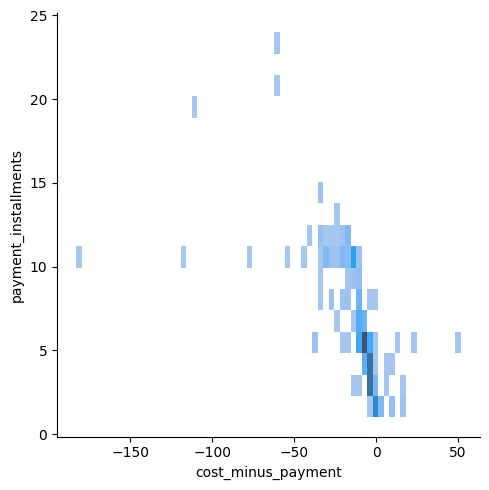

In [192]:
sns.displot(data=diff_stats,
            x='cost_minus_payment',
            y='payment_installments')

It seems we have a linear trend. The difference globally increase with the number of payment installments which could effectively correspond to fees/interests.

Nevertheless, Some payments are lower than the total price of the order (price + freight values). 

And when there is only one payment installment, there should not be fees.

In [195]:
diff_stats.query(ds.or_query_instruction('order_status', ['shipped', 'canceled']))

,cost_minus_payment,payment_installments,order_status,total_order_cost
1cd8d1567debd198821fe9d46d99b5b1,-25.12,13.0,canceled,104.88
dc6b76e937308e88a3464d0f4352b959,-5.99,5.0,shipped,46.00
ee38b45af2d4e705a88a37af7f0cda97,-6.89,5.0,canceled,52.84
f090de1b2ed9f4e251662cb31e3c7127,-0.92,2.0,shipped,26.71


Nothing particular here.

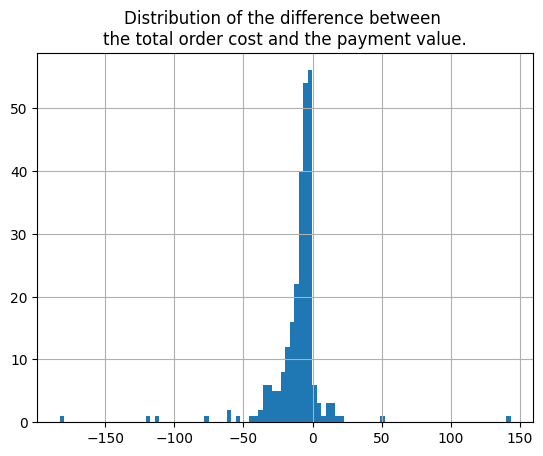

In [196]:
diff_stats.cost_minus_payment.hist(bins=100)
plt.title('Distribution of the difference between \n'
          'the total order cost and the payment value.')
plt.show()

When there is an inconsistency, It usually is the client that pays more than what is due. 
But some opposite cases sometimes occur!

In [197]:
diff_stats.query('payment_installments == 1')

,cost_minus_payment,payment_installments,order_status,total_order_cost
05d5a67b06f86425711075939a164657,-0.61,1.0,delivered,17.77
2240d9349c55949c40dbfcc98ece280c,-0.36,1.0,delivered,94.59
4387477eec4b3c89b39f3f454940d059,9.90,1.0,delivered,231.92
5af817dcc7682f13101dbdef134be4e0,-1.33,1.0,delivered,44.09
6508f1528c3648c8a9f751e811520269,-0.60,1.0,delivered,50.10
6cff0c3dacf64bb7cb2ad584b81b7d0d,2.60,1.0,delivered,33.43
6dcf0aeb8b1eb4021c26e1d0e9394979,14.95,1.0,delivered,333.92
6e57e23ecac1ae881286657694444267,16.50,1.0,delivered,350.41
6fa0c125ee7d870f6602c97e33d87bc5,1.60,1.0,delivered,47.31
8092da256aefda13b330290d2ca86521,10.39,1.0,delivered,115.65


Those are payments not corresponding to the order cost. When > 0, the client did not pay
the total cost. When negative, he paid too much.

In [198]:
# investigate large negative values.
df.query('cost_minus_payment < -100').query('order_status == "delivered"')


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment
11463,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,1.0,7721582bb750762d81850267d19881c1,0c8380b62e38e8a1e6adbeba7eb9688c,2016-10-14 12:02:21,19.83,17.00,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
11464,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,2.0,65bb78cf0bbc3ca6406f30e6793736f9,391fc6631aebcf3004804e51b40bcf1e,2016-10-14 12:02:20,39.90,19.24,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
11465,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,3.0,7721582bb750762d81850267d19881c1,0c8380b62e38e8a1e6adbeba7eb9688c,2016-10-14 12:02:21,19.83,17.00,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
11466,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,4.0,65bb78cf0bbc3ca6406f30e6793736f9,391fc6631aebcf3004804e51b40bcf1e,2016-10-14 12:02:20,39.90,19.24,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
11467,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,5.0,7721582bb750762d81850267d19881c1,0c8380b62e38e8a1e6adbeba7eb9688c,2016-10-14 12:02:21,19.83,17.00,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
11468,5263febf1413e9a60ceb7b842008b7ef,6f90ec5150be36c4475835b5941ab56f,82980,curitiba,PR,6e5fe7366a2e1bfbf3257dba0af1267f,delivered,2016-10-09 22:36:25,2016-10-10 12:02:19,2016-10-14 12:02:21,2016-10-17 13:02:21,2016-12-06,6.0,65bb78cf0bbc3ca6406f30e6793736f9,391fc6631aebcf3004804e51b40bcf1e,2016-10-14 12:02:20,39.90,19.24,1.0,credit_card,10.0,406.92,287.91,406.92,-119.01
65600,d8acb46c718975948423dbf1b603b959,3629a4b18f2eb69e03f153158e48d2cc,78580,alta floresta,MT,ce6d150fb29ada17d2082f4847107665,delivered,2018-01-25 11:17:02,2018-01-27 12:35:38,2018-01-29 18:32:40,2018-02-21 17:38:51,2018-03-08,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-02-07 12:31:37,1299.00,104.66,1.0,credit_card,10.0,1586.47,1403.66,1586.47,-182.81
81954,0c155574f4f4d27594dbdd37731a6ecb,b8b3c435a58aebd788a477bed8342910,95585,arroio do sal,RS,70b742795bc441e94a44a084b6d9ce7a,delivered,2017-08-24 10:29:36,2017-08-24 10:35:22,2017-08-30 15:28:21,2017-09-12 20:27:39,2017-09-20,1.0,1dd284c37ca97cbb86c029c65fb9a494,070d165398b553f3b4b851c216b8a358,2017-08-30 10:35:22,269.99,196.94,1.0,credit_card,20.0,578.82,466.93,578.82,-111.89


Those cases where the client paid much more than the initial order cost seem plausible because it concerns expensive orders paid in several times.

### 2.5.3.  [&#9650;](#toc0_) <a id='toc2_5_3_'></a>Personal note

In [199]:
# generating total payment value from the order_payments dataframe 
# would have probably been much easier and faster
ex4 = order_payments.groupby('order_id').filter(lambda x: len(x) == 29)
display(ex4.sort_values("payment_sequential"))
ex4_total_payment = ex4.payment_value.sum()
ex4_total_payment

,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


457.99

In [200]:
df.query("order_id == 'fa65dad1b0e818e3ccc5cb0e39231352'")['total_order_cost'].head(1)

30561    457.99
Name: total_order_cost, dtype: float64

Only a few customers bought several time (~3 300).

Let's find an example.

In [ ]:
best_orderer = (customers.customer_unique_id
                .value_counts()
                .sort_values()
                .tail(1)
                .index[0])
df.query('customer_unique_id == @best_orderer')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_category_name_english
17017,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,b850a16d8faf65a74c51287ef34379ce,delivered,2017-11-22 20:01:53,2017-11-22 20:12:32,2017-11-24 16:07:56,2017-11-27 18:49:13,2017-12-04 00:00:00,1.0,5bccc8fe44471df6c7b7e08176837d2f,1da3aeb70d7989d1e6d9b0e887f97c23,2017-11-28 20:12:32,13.99,7.78,68faf98deb4bc8c25eb42f07a1216f46,5.0,NaN,NaN,2017-11-28 00:00:00,2017-11-28 21:59:16,1.0,credit_card,1.0,21.77,esporte_lazer,sports_leisure
18370,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,delivered,2018-05-21 22:44:31,2018-05-22 01:53:35,2018-05-22 14:18:00,2018-05-23 15:33:09,2018-05-29 00:00:00,1.0,5cb96c51c55f57503465e4d2558dc053,db4350fd57ae30082dec7acbaacc17f9,2018-05-24 01:53:35,45.99,7.39,cb1172e327bba1a8784de2ecc9107c2e,5.0,NaN,NaN,2018-05-24 00:00:00,2018-05-24 18:57:51,1.0,credit_card,1.0,53.38,esporte_lazer,sports_leisure
19960,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,c2213109a2cc0e75d55585b7aaac6d97,delivered,2018-08-07 23:32:14,2018-08-07 23:45:21,2018-08-09 13:35:00,2018-08-10 20:26:44,2018-08-13 00:00:00,1.0,de7df82eb1e48c456b020c2cfb03aeed,1da3aeb70d7989d1e6d9b0e887f97c23,2018-08-12 23:45:21,26.99,7.45,ae4bcc3a247dd80b95ec803024afc142,5.0,NaN,NaN,2018-08-11 00:00:00,2018-08-12 22:47:47,1.0,credit_card,1.0,34.44,esporte_lazer,sports_leisure
43391,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,369634708db140c5d2c4e365882c443a,delivered,2017-06-18 22:56:48,2017-06-18 23:10:19,2017-06-19 20:12:26,2017-06-23 12:55:50,2017-07-07 00:00:00,1.0,d83509907a19c72e1e4cdde78b8177ec,94e93ce877be27a515118dbfd2c2be41,2017-06-22 23:10:19,39.90,11.85,7ecc7adba17766dab9097a0116a75a66,5.0,NaN,NaN,2017-06-25 00:00:00,2017-06-26 20:53:55,1.0,credit_card,2.0,51.75,esporte_lazer,sports_leisure
45721,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,bf92c69b7cc70f7fc2c37de43e366173,delivered,2017-07-24 22:11:50,2017-07-24 22:25:14,2017-07-26 01:42:03,2017-07-31 16:59:58,2017-08-15 00:00:00,1.0,e01bc2ad5c6f46c0f53f73379fcd602e,a3a38f4affed601eb87a97788c949667,2017-07-30 22:25:14,149.90,16.81,8858e37108a15029eef04f510161fb8a,5.0,NaN,NaN,2017-08-01 00:00:00,2017-08-02 01:22:24,1.0,credit_card,3.0,166.71,esporte_lazer,sports_leisure
48127,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,4f62d593acae92cea3c5662c76122478,delivered,2017-07-18 23:10:58,2017-07-18 23:23:26,2017-07-20 19:00:02,2017-07-21 16:19:40,2017-07-31 00:00:00,1.0,94cc774056d3f2b0dc693486a589025e,1da3aeb70d7989d1e6d9b0e887f97c23,2017-07-24 23:23:26,13.99,7.78,cb44e7ba6bacbf6f348aec2b9ab56790,5.0,NaN,NaN,2017-07-22 00:00:00,2017-07-24 12:52:56,1.0,credit_card,1.0,21.77,fashion_bolsas_e_acessorios,fashion_bags_accessories
58223,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,112eb6f37f1b9dabbced368fbbc6c9ef,delivered,2018-07-23 21:53:02,2018-07-24 10:31:34,2018-07-25 10:25:00,2018-07-26 18:29:28,2018-08-02 00:00:00,1.0,41f6cb7c3b1200749326e50106f32d58,db4350fd57ae30082dec7acbaacc17f9,2018-07-30 09:43:43,99.00,8.85,8accb409ffddfd1694113c3a0e6e0f70,5.0,NaN,NaN,2018-07-27 00:00:00,2018-07-28 13:07:54,1.0,credit_card,1.0,107.85,esporte_lazer,sports_leisure
63056,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,519203404f6116d40

In [ ]:
df.query('order_id ==@largest_order_id')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_category_name_english
56450,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,1.0,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56451,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,2.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56452,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,3.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56453,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,4.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56454,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,5.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56455,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28 00:00:00,6.0,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89,e8236fe7b6e1bdd513a500de361e2b87,1.0,NaN,Eu estou tentando cancelar faz tempo devido o valor do frete muito abusivo,2017-07-30 00:00:00,2017-07-30 14:19:07,1.0,credit_card,2.0,196.11,beleza_saude,health_beauty
56456,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-3

## 2.6.  [&#9650;](#toc0_) <a id='toc2_6_'></a>Merged_df <-- order_reviews

In [201]:
df = pt.merge_and_display(df, order_reviews, on="order_id")

shape before merging : (118434, 25)
shape of the right df: (99224, 3)
shape after merging : (119143, 27)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

As we see the length is increasing, that means there sometimes are multiple reviews for a same row?

In [202]:
# Getting similar rows without considering the review information
cols = df.columns.drop(['review_id', 'review_score'])
same_rows = df.loc[df.duplicated(cols, keep=False)]
same_rows.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score
511,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,1.0,b2fb8ccacff645e701cd692064ad09c9,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,f3b4c0f29e58c71d20f64876f5099617,5.0
512,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,1.0,b2fb8ccacff645e701cd692064ad09c9,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,0de114480bf17bae6e447ca8dff91d5e,5.0
513,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,2.0,315c6373ff469f7b7f60bbb36c319f7b,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,f3b4c0f29e58c71d20f64876f5099617,5.0
514,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,2.0,315c6373ff469f7b7f60bbb36c319f7b,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,0de114480bf17bae6e447ca8dff91d5e,5.0
515,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,3.0,54971206521793b44053a9c348d148c2,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,f3b4c0f29e58c71d20f64876f5099617,5.0
516,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,3.0,54971206521793b44053a9c348d148c2,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,36.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,0de114480bf17bae6e447ca8dff91d5e,5.0
517,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,4.0,54d9260785f11c05ad373ce8465212da,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,47.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,f3b4c0f29e58c71d20f64876f5099617,5.0
518,0e772d9e02b17408e716f35cd1dcc222,b09f1bff1aff13c997af071602bc048b,3755,sao paulo,SP,c27cd942c2a926d25153090afa106ceb,delivered,2017-06-15 14:26:01,2017-06-15 14:45:15,2017-06-20 14:22:03,2017-06-26 11:23:32,2017-07-10,4.0,54d9260785f11c05ad373ce8465212da,d1c281d3ae149232351cd8c8cc885f0d,2017-06-22 14:45:15,47.99,11.85,1.0,credit_card,2.0,206.36,206.36,206.36,0.0,0de114480bf17bae6e447ca8dff91d5e,5.0
620,8d13b315c8e8e3d9011c9e9267cb8a70,63df651d5e8adb6a0e4baeb66a0eea37,16202,birigui,SP,bbf6a647ecc68aa5e79d2cd75ef44c68,delivered,2017-09-01 10:33:16,2017-09-02 10:45:16,2017-09-05 12:33:20,2017-09-13 18:53:49,2017-09-22,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,

In [203]:
initial_review_order = pd.read_csv('./csv_files/olist_order_reviews_dataset.csv')

In [204]:
initial_review_order.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [205]:
import random

In [206]:
# Display some cases where there are multiple reviews for an order.
for id in random.choices(same_rows.order_id.unique(), k=20):
    display(initial_review_order.query('order_id == @id'))

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
69353,686eece1abf58531d6f183ce10905c95,151e44f3dd461fe0838b6f59f884749f,1,NaN,Não foi entregue o produto \r\n,2018-03-23 00:00:00,2018-03-26 11:46:01
89736,588785ae600e2f07f4cbb031d2208ba3,151e44f3dd461fe0838b6f59f884749f,4,NaN,NaN,2018-03-09 00:00:00,2018-03-11 18:25:43


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
67279,44e00fb29fcf44cda84d272d637088a9,6297b306b33b7a9028dfaa203b9742a3,5,NaN,NaN,2017-09-27 00:00:00,2017-09-28 08:25:00
81833,8ce5b6e9591a327fe7909a9e63c29ccb,6297b306b33b7a9028dfaa203b9742a3,5,NaN,"Produto excelente, de boa qualidade. Na foto parece mais claro do que é. Mas gostei mesmo assim.",2017-09-29 00:00:00,2017-10-02 20:21:18


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
42373,1c0dcb67a987eac41f18d8d2556c1059,7ceb3c8bbf48eaa776064d56012afbc1,5,NaN,NaN,2018-03-13 00:00:00,2018-03-15 20:19:43
74046,0a2d1206f8b2473cd3ddf69b51bca98a,7ceb3c8bbf48eaa776064d56012afbc1,5,NaN,NaN,2018-03-14 00:00:00,2018-03-16 09:05:13


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46867,bea027d5b8f46e93c2fc10e554bffa84,2477bfb97977363803e3cdd7c6805198,4,NaN,NaN,2017-12-19 00:00:00,2017-12-19 21:44:16
80164,ec631e163f9b436499fd8fcda6ea3b03,2477bfb97977363803e3cdd7c6805198,5,NaN,NaN,2017-12-20 00:00:00,2017-12-21 02:47:14


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
23650,37bd872bb86f7492f666ce6a2def8c10,8681822ccf2aaea9124f49a2a6dba7b1,1,NaN,Comprei e paguei um produto em 03/03/2018.\r\nNo dia 19/03 recebi mensagem da lannister.com dizendo que houve problema na entrega nos Correios. Desde então tenho reclamado sem obter nenhuma resposta.,2018-03-15 00:00:00,2018-03-23 23:31:37
71885,be875debcda2c703ea8ab250824860f1,8681822ccf2aaea9124f49a2a6dba7b1,1,NaN,"Adquiri o produto através da lannister.com em 02/03/2018, mas o até esta data não recebi o produto.",2018-03-25 00:00:00,2018-03-26 21:15:33


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
41735,f24e1946d658c13928818f1a73b6d899,c4f710df20f7d1500da1aef81a993f65,5,NaN,Excelente produto.\r\nObrigada,2016-10-27 00:00:00,2016-10-28 12:21:53
75532,87159a093663b2a1bb847dbb84879c41,c4f710df20f7d1500da1aef81a993f65,5,NaN,Excelente produto.\r\nVendedor nota 1000,2016-10-29 00:00:00,2016-10-31 20:00:13


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
28801,7d35852d24f13f1afdc3ea193e943842,574c4ecf7699daffc21fc04eb876b8a8,5,NaN,Muito bom,2017-06-27 00:00:00,2017-06-28 23:40:15
76991,eb632ac43fa0e0b1455adde073a04d0f,574c4ecf7699daffc21fc04eb876b8a8,5,NaN,Muito bom,2017-06-27 00:00:00,2017-06-28 23:39:35


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
43511,45492b637a77865609f86bb4b99ed6d9,2a680095a7549ad07085fb6863f91316,5,NaN,NaN,2017-11-25 00:00:00,2017-11-27 19:20:29
98316,76bea9c81fcf08bfb8e6c21e25a4976e,2a680095a7549ad07085fb6863f91316,5,NaN,NaN,2017-11-24 00:00:00,2017-11-27 00:52:57


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
15734,76b7f392d84986f8c04c229fa4783d5e,ce5ac3d77cca9ee37ace392eb33cee3f,3,NaN,"Prazo compatível ao preço cobrado, ágil.",2017-10-25 00:00:00,2017-10-27 16:12:43
82875,3cd0cdb556ae14cfc2d463954c86aff4,ce5ac3d77cca9ee37ace392eb33cee3f,3,NaN,NaN,2017-10-31 00:00:00,2017-11-01 10:51:17


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
6798,662d2c533d56243557c12699eff9d5a3,aa20064eef8808d62ed9ac5286ec0796,5,NaN,NaN,2017-04-14 00:00:00,2017-04-16 19:41:32
74249,d83391dee674f4df74b3e72e31774030,aa20064eef8808d62ed9ac5286ec0796,5,NaN,NaN,2017-04-20 00:00:00,2017-04-23 11:14:56


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
14800,9216f81424452eb18e3ad1bb6f4a5028,ec0dc4b572563095782c3e96a9f4d205,5,NaN,NaN,2017-07-28 00:00:00,2017-07-28 23:37:20
90665,5ccf9e14796ecb4f98ce11d896e9f0c0,ec0dc4b572563095782c3e96a9f4d205,5,NaN,NaN,2017-07-25 00:00:00,2017-07-26 00:11:16


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
21124,e7fe983abe23c4a31196a9f48576e1da,964d7960d6a2fad0dbe19f9365bfac2d,4,NaN,NaN,2018-07-28 00:00:00,2018-07-29 17:19:06
27086,d874293068e4b9c28021c43a01f45afb,964d7960d6a2fad0dbe19f9365bfac2d,4,NaN,NaN,2018-07-28 00:00:00,2018-07-29 19:45:57


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
68910,ec170f7c4c9fc6c3c131844be4d51dc2,7efd95780798d3826acbaafd16953320,5,NaN,NaN,2017-11-30 00:00:00,2017-12-06 21:26:56
86111,875f18c7bc42c18b45a34270e327102b,7efd95780798d3826acbaafd16953320,5,NaN,NaN,2017-11-29 00:00:00,2017-12-06 21:28:34


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
17890,7210013d1d7478bd9207fa34d4b88e46,2143393cca994a4b8235bc1d67ded772,5,NaN,Tudo ocorreu bem e era o que eu queria,2018-03-06 00:00:00,2018-03-07 18:17:03
71147,ad134dca6a26a91326f970a15e4c9cba,2143393cca994a4b8235bc1d67ded772,5,NaN,Tudo Correu bem e era o que eu queria,2018-03-06 00:00:00,2018-03-07 18:17:53


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
42870,f56e0a08e5f3df2afdc49b16eb4393db,7f9089a3fbe75385f39d5924c2928352,5,NaN,NaN,2017-12-06 00:00:00,2017-12-06 09:53:56
76980,c76d214753231e86d69154aca0bdfdda,7f9089a3fbe75385f39d5924c2928352,5,NaN,NaN,2017-12-13 00:00:00,2017-12-13 16:56:06


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
33047,6666d0fe60543025207c2b0abd2f8b71,37732eb932f8b2b2b3d7cef77833eec1,5,NaN,NaN,2017-11-09 00:00:00,2017-11-12 00:01:42
96824,0b9af3c12843b743f612ca8abbc33e83,37732eb932f8b2b2b3d7cef77833eec1,5,NaN,NaN,2017-11-02 00:00:00,2017-11-02 22:36:20


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
2952,c444278834184f72b1484dfe47de7f97,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-08 00:00:00,2017-02-14 13:58:48
13982,72a1098d5b410ae50fbc0509d26daeb9,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-07 00:00:00,2017-02-10 10:46:09
62728,44f3e54834d23c5570c1d010824d4d59,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-09 00:00:00,2017-02-09 09:07:28


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
58558,58b5d073a299b6f3d6cd6e11e39fe269,34080c138f92d6ea70448a0403b25d00,4,NaN,Gosto muito de comprar no baratheon,2017-05-24 00:00:00,2017-05-26 14:59:26
85638,b8c9100d387b8128d79488d483b945c2,34080c138f92d6ea70448a0403b25d00,4,NaN,Lija otima,2017-05-24 00:00:00,2017-05-25 10:43:24


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
41110,745f85cf53a80fb4c98b2cbb595c0821,25cb912c6742e486c6988aaf2c8f221b,5,NaN,Nossa muito bom super recomendo esta loja muito obrigada.,2018-03-14 00:00:00,2018-03-14 23:31:45
83487,b392c6237b696220b1fdda5532c1b95d,25cb912c6742e486c6988aaf2c8f221b,5,NaN,Bom gostei entregue dentro do prazo e só tenho agradecer.,2018-03-24 00:00:00,2018-03-24 20:52:44


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
61328,667dd2be07177cdc16741b47c0ca0311,baed56f3eda9223b74c6cf175f05678e,5,NaN,NaN,2018-04-05 00:00:00,2018-04-05 20:42:48
98677,8ae90d960cb871f44ebf423568e2985d,baed56f3eda9223b74c6cf175f05678e,5,NaN,NaN,2018-04-10 00:00:00,2018-04-10 19:10:35


In [207]:
df.query('order_id =="c88b1d1b157a9999ce368f218a407141"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score
16015,ae0fb7b01c548c4fd30f19f55453ec4a,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,c88b1d1b157a9999ce368f218a407141,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,42.77,42.77,0.0,ffb8cff872a625632ac983eb1f88843c,3.0
16016,ae0fb7b01c548c4fd30f19f55453ec4a,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,c88b1d1b157a9999ce368f218a407141,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,42.77,42.77,0.0,202b5f44d09cd3cfc0d6bd12f01b044c,5.0
16017,ae0fb7b01c548c4fd30f19f55453ec4a,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,c88b1d1b157a9999ce368f218a407141,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01,1.0,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,1.0,credit_card,4.0,42.77,42.77,42.77,0.0,fb96ea2ef8cce1c888f4d45c8e22b793,5.0


In [208]:
df.query('order_id =="b8fdf0a70040d5461adca8f95ba4171a"')


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score
29504,a56a99918e8686b7d35af612dd30e86e,45df9d71b80f651fcfd26763eebd027a,23942,angra dos reis,RJ,b8fdf0a70040d5461adca8f95ba4171a,delivered,2017-12-01 12:18:11,2017-12-02 02:38:25,2017-12-04 17:52:59,2018-01-05 17:06:15,2018-01-04,1.0,f2f411f86bd5bd427e28e2a30771761f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 02:38:25,89.9,17.88,1.0,boleto,1.0,107.78,107.78,107.78,0.0,ba69d8c9ff524792f380378510bdae64,3.0
29505,a56a99918e8686b7d35af612dd30e86e,45df9d71b80f651fcfd26763eebd027a,23942,angra dos reis,RJ,b8fdf0a70040d5461adca8f95ba4171a,delivered,2017-12-01 12:18:11,2017-12-02 02:38:25,2017-12-04 17:52:59,2018-01-05 17:06:15,2018-01-04,1.0,f2f411f86bd5bd427e28e2a30771761f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 02:38:25,89.9,17.88,1.0,boleto,1.0,107.78,107.78,107.78,0.0,854ce3274684322d2ad677b5246530c0,1.0


- review_creation_date : Shows the date in which the satisfaction survey was sent to the customer.
- review_answer_timestamp : Shows satisfaction survey answer timestamp.

***
My hypothesis :

- Olist sometimes send multiple satisfaction surveys (when the client does not answer). 
- One can answer multiple times to the same survey and they sometimes answer several surveys.

Nevertheless, it is strange to see different score and review comments on the same (order, item) done the same day. In that case I could average.

It is understandable that the review changes through time (the seller does a goodwill gesture or conversely the item seemed good when received, but was disappointing after few days of use.) Then, we could choose to average, or keep the last satisfaction.

I think that the mean is simpler to compute, and that it is enough.

I could generate a feature "was disappointed at any moment" before averaging, but I think if I keep track of the average, the min and the max, the information is pretty much there.



In [209]:
same_rows.order_id.nunique()

547

Those remarks only concern a small part of the orders : 547.

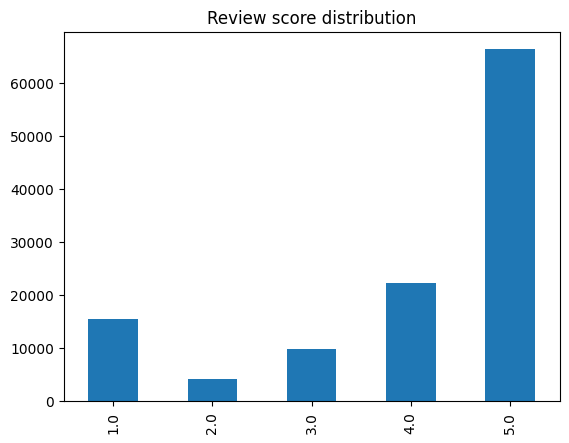

In [210]:
(df.review_score
 .value_counts()
 .sort_index()
 .plot(kind='bar', title="Review score distribution")
)
plt.show()

## 2.7.  [&#9650;](#toc0_) <a id='toc2_7_'></a>Merged_df <-- products

In [211]:
df = pt.merge_and_display(df, products, on="product_id")

shape before merging : (119143, 27)
shape of the right df: (32951, 2)
shape after merging : (119143, 28)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

one_to_one match here

In [212]:
df.product_category_name.value_counts()

cama_mesa_banho                                   11988
beleza_saude                                      10032
esporte_lazer                                      9004
moveis_decoracao                                   8832
informatica_acessorios                             8150
utilidades_domesticas                              7380
relogios_presentes                                 6213
telefonia                                          4726
ferramentas_jardim                                 4590
automotivo                                         4400
brinquedos                                         4281
cool_stuff                                         3999
perfumaria                                         3589
bebes                                              3204
eletronicos                                        2846
papelaria                                          2625
fashion_bolsas_e_acessorios                        2170
pet_shop                                        

In [213]:
# Add english translation
df = pt.merge_and_display(df, product_category_name_translation, on="product_category_name")

shape before merging : (119143, 28)
shape of the right df: (71, 2)
shape after merging : (119143, 29)


customer_id                      1.000000
customer_unique_id               1.000000
customer_zip_code_prefix         1.000000
customer_city                    1.000000
customer_state                   1.000000
order_id                         1.000000
order_status                     1.000000
order_purchase_timestamp         1.000000
order_approved_at                0.998514
order_delivered_carrier_date     0.982492
order_delivered_customer_date    0.971287
order_estimated_delivery_date    1.000000
order_item_id                    0.993008
product_id                       0.993008
seller_id                        0.993008
shipping_limit_date              0.993008
price                            0.993008
freight_value                    0.993008
payment_sequential               0.999975
payment_type                     0.999975
payment_installments             0.999975
payment_value                    0.999975
total_order_cost                 1.000000
total_payment_value              1

In [214]:
df.product_category_name_english.value_counts().head(20)

bed_bath_table              11988
health_beauty               10032
sports_leisure               9004
furniture_decor              8832
computers_accessories        8150
housewares                   7380
watches_gifts                6213
telephony                    4726
garden_tools                 4590
auto                         4400
toys                         4281
cool_stuff                   3999
perfumery                    3589
baby                         3204
electronics                  2846
stationery                   2625
fashion_bags_accessories     2170
pet_shop                     2030
office_furniture             1788
consoles_games               1192
Name: product_category_name_english, dtype: int64

In [215]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,146.87,146.87,0.0,88b8b52d46df026a9d1ad2136a59b30b,4.0,moveis_escritorio,office_furniture
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1.0,credit_card,8.0,335.48,335.48,335.48,0.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,utilidades_domesticas,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1.0,credit_card,7.0,157.73,157.73,157.73,0.0,5ad6695d76ee186dc473c42706984d87,5.0,moveis_escritorio,office_furniture
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1.0,credit_card,1.0,173.30,173.30,173.30,0.0,059a801bb31f6aab2266e672cab87bc5,5.0,moveis_escritorio,office_furniture
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1.0,credit_card,8.0,252.25,252.25,252.25,0.0,8490879d58d6c5d7773f2739a03f089a,5.0,casa_conforto,home_confort


In [216]:
# recast dates because nulls were introduced, thus changing the dtype
orders_date_columns = ['order_purchase_timestamp',
                       'order_approved_at',
                       'order_delivered_carrier_date',
                       'order_delivered_customer_date',
                       'order_estimated_delivery_date']

for col in orders_date_columns:
    df.loc[:, col] = pd.to_datetime(df[col])

/tmp/ipykernel_4554/778624003.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_4554/778624003.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = pd.to_datetime(df[col])
/tmp/ipykernel_4554/778624003.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc

In [217]:
df.to_csv('merged_df.csv.gz', index=False)

In [ ]:
df = pd.read_csv('merged_df.csv.gz')

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  category      
 4   customer_state                 119143 non-null  category      
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  category      
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   order_approved_at              118966 non-null  datetime64[ns]
 9   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 10  order_delivered_customer_date  115722 non-null  datetime64[ns]
 11  

## 2.8.  [&#9650;](#toc0_) <a id='toc2_8_'></a>Review score vs status

In [219]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'total_order_cost', 'total_payment_value',
       'cost_minus_payment', 'review_id', 'review_score',
       'product_category_name', 'product_category_name_english'],
      dtype='object')

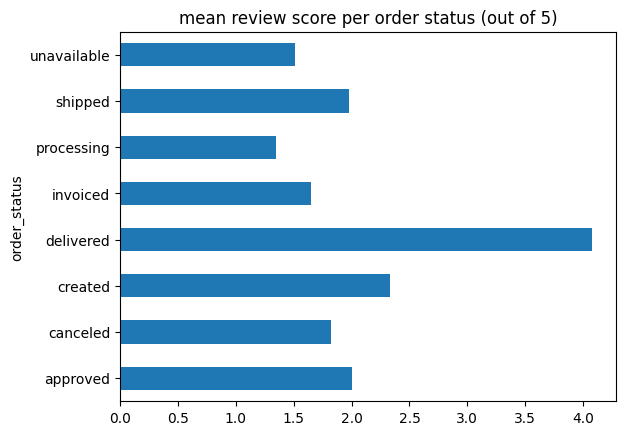

In [220]:
(df.
 groupby('order_status')['review_score']
 .mean()
 .plot(kind='barh', title="mean review score per order status (out of 5)")
)
plt.show()

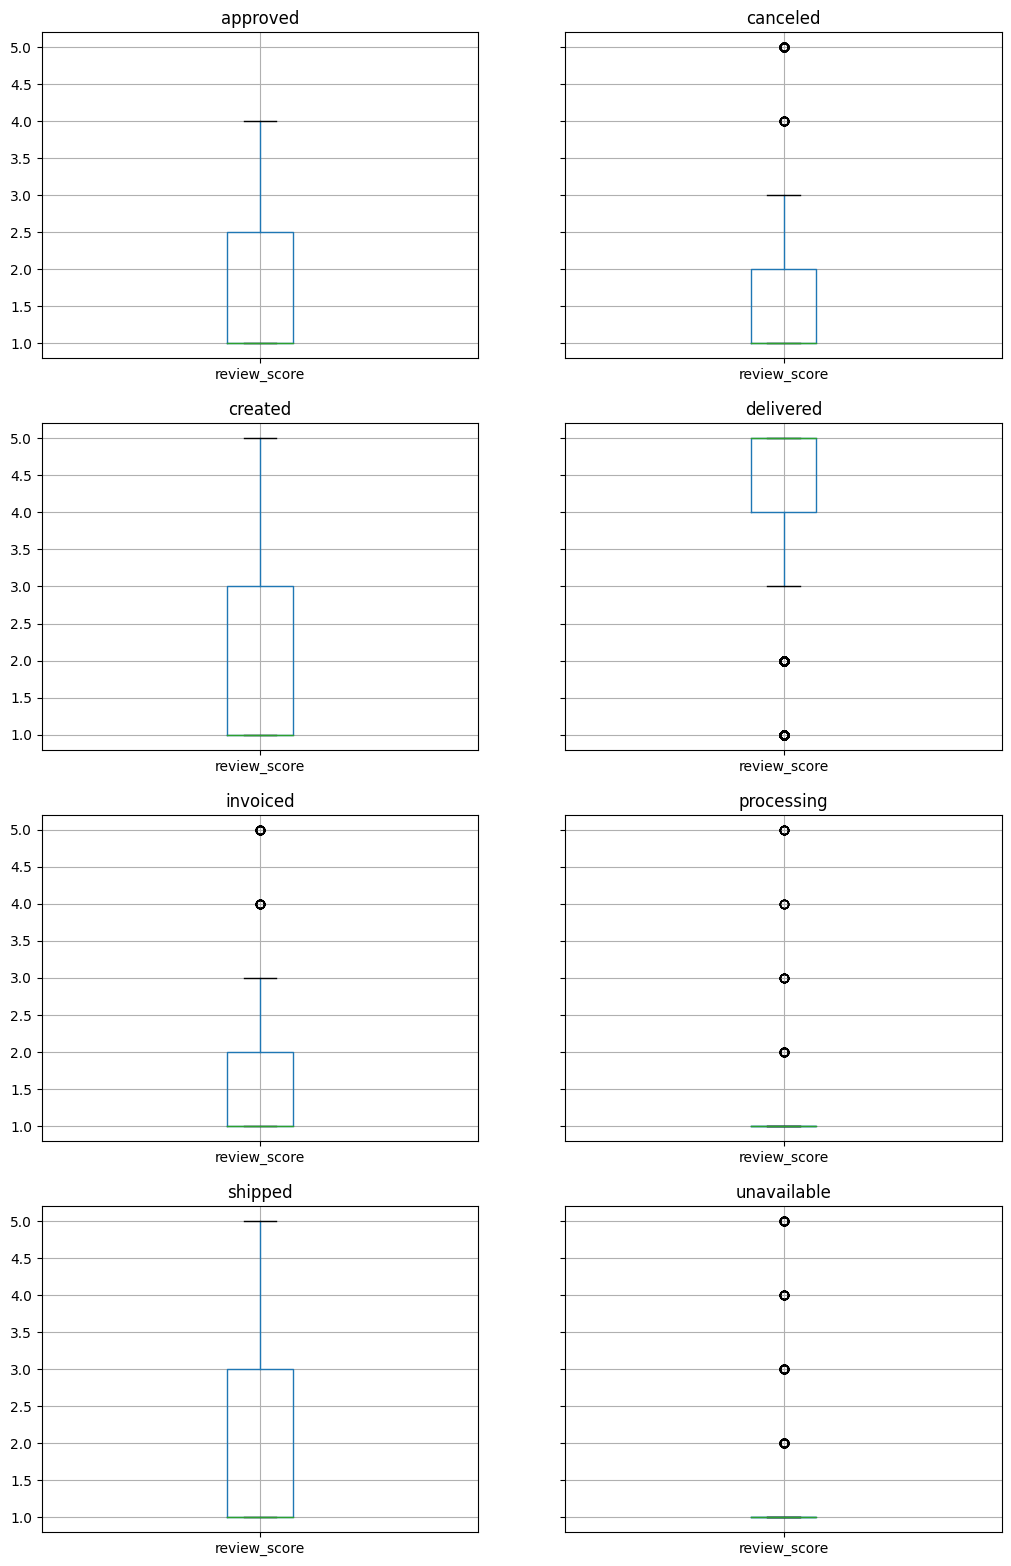

In [221]:
(df.
 groupby('order_status')
 .boxplot(column=['review_score'], figsize=(12,20), layout=(4,2))
)
plt.show()

Unavailable nad processing are what frustrate the most the clients. But globally, it is almost as frustrating as it gets with unavailable for every order status, except for delivered.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Features engineering

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Design on 5 clients example

In [222]:
# Search some clients ids (complex enough for testing purpose)
n = 0
for name, group in df.groupby("customer_unique_id").__iter__():
    if (len(group) > 10) & (group.groupby('order_id').ngroups >= 2):
        print(name)
        n += 1
        if n == 3:
            break

07ff81a9676efa0286ddd3f09e7c0063
096e351116755fe4c3c1e48eaf301a41
0f5ac8d5c31de21d2f25e24be15bbffb


In [244]:
df.query("cost_minus_payment > 0.05").head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
2092,fcb4cecebc159e210cd769d5b767d113,aef59fd9f7310b6ea1600876c510024f,22230,rio de janeiro,RJ,6fa0c125ee7d870f6602c97e33d87bc5,delivered,2018-08-09 19:32:42,2018-08-20 15:59:54,2018-08-14 15:43:00,2018-08-17 20:51:25,2018-08-23,1.0,70e0c10acc3dd72e17f2136ddb027317,ce27a3cc3c8cc1ea79d11e561e9bebb6,2018-08-15 16:31:14,31.99,15.32,1.0,debit_card,1.0,45.71,47.31,45.71,1.60,6dbe30770adf8a80fee0512a152c8c71,4.0,cool_stuff,cool_stuff
2420,3a412111e4f293539eae05b502fc63de,f7c20fc3dc5222bc4389740958175652,8220,sao paulo,SP,e73fe43cdcd166f7f0c6e3c2bf11a917,delivered,2018-08-09 18:06:43,2018-08-20 15:57:28,2018-08-14 14:48:00,2018-08-15 15:46:38,2018-08-16,1.0,544c14365db76307e0820a1468ed8114,334cab711dee080b079fa5779b584783,2018-08-15 16:31:14,49.90,9.10,1.0,debit_card,1.0,56.50,59.00,56.50,2.50,07356e089552984948d612ea0899245b,5.0,moveis_decoracao,furniture_decor
6388,4f061e67c05a2736e7c07286ff3fa787,fded88a1576bd3a1383116738e43fb6c,71927,brasilia,DF,aa6bd33ba1853d846d3085a88ae37083,delivered,2018-08-10 21:36:37,2018-08-10 21:50:23,2018-08-13 15:18:00,2018-08-17 17:04:32,2018-08-23,1.0,4f45fa1109c51a1b799a8fe7a3f9a854,0ea22c1cfbdc755f86b9b54b39c16043,2018-08-14 21:50:23,19.90,15.24,1.0,credit_card,1.0,25.14,35.14,25.14,10.00,66af6c5a072d8c70f22b4ad05245bf28,5.0,fashion_bolsas_e_acessorios,fashion_bags_accessories
9744,02ae654741ad895368bd9ffc371893e5,507f6af076decee5860e7b57d23ca4aa,4547,sao paulo,SP,320dcf288de15e4ff06ebbfce4e42c78,delivered,2018-08-26 08:40:36,2018-08-26 08:50:10,2018-08-27 14:53:00,2018-08-30 17:38:41,2018-09-10,1.0,a1b35ee994b8c571119976c30aa07efe,709e16e2b25c7474d980076c6bfc4806,2018-08-29 08:50:10,29.90,12.88,1.0,credit_card,3.0,81.37,87.55,81.37,6.18,88a2f90d037d09dd8041621531e1b9ab,3.0,beleza_saude,health_beauty
9745,02ae654741ad895368bd9ffc371893e5,507f6af076decee5860e7b57d23ca4aa,4547,sao paulo,SP,320dcf288de15e4ff06ebbfce4e42c78,delivered,2018-08-26 08:40:36,2018-08-26 08:50:10,2018-08-27 14:53:00,2018-08-30 17:38:41,2018-09-10,2.0,c9676685ee3aec26dd274549d54b85f6,709e16e2b25c7474d980076c6bfc4806,2018-08-29 08:50:10,31.90,12.87,1.0,credit_card,3.0,81.37,87.55,81.37,6.18,88a2f90d037d09dd8041621531e1b9ab,3.0,beleza_saude,health_beauty


In [253]:
# Create and displaying those clients (client1, ..., client4)
clients_id = ["0058f300f57d7b93c477a131a59b36c3",
              "00cc12a6d8b578b8ebd21ea4e2ae8b27",
              "0f5ac8d5c31de21d2f25e24be15bbffb",
              "6fbc7cdadbb522125f4b27ae9dee4060",
              "fded88a1576bd3a1383116738e43fb6c",]

for n, client_id in enumerate(clients_id):
       var_name = "client" + str(n+1)     
       print(var_name)  
       print(client_id)
       exec(var_name
            + " = df.query('customer_unique_id == @client_id')")
       display(eval(var_name))

# Join them in a dict
example_clients = {("client" + str(n)): eval("client" + str(n))
                   for n in range(1, len(clients_id)+1)}

client1
0058f300f57d7b93c477a131a59b36c3


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
43561,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,salvador,BA,81a93b2fa39e104b865b2bc471c16008,delivered,2018-03-22 18:09:41,2018-03-22 18:27:58,2018-03-23 22:28:51,2018-04-04 23:05:57,2018-04-16,1.0,4630761de87581e8b659dc77bb7eb4ee,dbc22125167c298ef99da25668e1011f,2018-03-28 18:27:58,72.58,23.44,1.0,voucher,1.0,79.56,96.02,96.02,0.0,a68ed61c3df4e6277c6cecfc8d7fb46c,5.0,malas_acessorios,luggage_accessories
43562,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,salvador,BA,81a93b2fa39e104b865b2bc471c16008,delivered,2018-03-22 18:09:41,2018-03-22 18:27:58,2018-03-23 22:28:51,2018-04-04 23:05:57,2018-04-16,1.0,4630761de87581e8b659dc77bb7eb4ee,dbc22125167c298ef99da25668e1011f,2018-03-28 18:27:58,72.58,23.44,2.0,voucher,1.0,16.46,96.02,96.02,0.0,a68ed61c3df4e6277c6cecfc8d7fb46c,5.0,malas_acessorios,luggage_accessories
73597,f530197ea86ced9488a03d055e118ebf,0058f300f57d7b93c477a131a59b36c3,40731,salvador,BA,2cfc79d9582e9135c0a9b61fa60e6b21,canceled,2018-02-19 17:11:34,2018-02-19 17:20:52,2018-02-20 18:58:43,NaT,2018-03-15,1.0,6bd248f93425ceeb625a8a97e2404112,dbc22125167c298ef99da25668e1011f,2018-02-23 17:20:52,59.90,19.66,1.0,voucher,1.0,79.56,79.56,79.56,0.0,3f7f1106182dd7f37642b8a3385314c6,1.0,papelaria,stationery


client2
00cc12a6d8b578b8ebd21ea4e2ae8b27


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
797,102fc0966044243157bb81e4ee0a251e,00cc12a6d8b578b8ebd21ea4e2ae8b27,3178,sao paulo,SP,d61b915b69851aec8a8865f36cfd793e,delivered,2017-03-21 19:25:23,2017-03-21 19:25:23,2017-03-23 16:00:01,2017-03-28 14:54:11,2017-04-07,1.0,48ee9be392f28ae3a64518a070f4d06a,4a3ca9315b744ce9f8e9374361493884,2017-03-27 19:25:23,69.9,11.88,1.0,boleto,1.0,81.78,81.78,81.78,0.0,dcecf8e3ba584a9ebe49439490a914bb,5.0,cama_mesa_banho,bed_bath_table
798,102fc0966044243157bb81e4ee0a251e,00cc12a6d8b578b8ebd21ea4e2ae8b27,3178,sao paulo,SP,d61b915b69851aec8a8865f36cfd793e,delivered,2017-03-21 19:25:23,2017-03-21 19:25:23,2017-03-23 16:00:01,2017-03-28 14:54:11,2017-04-07,1.0,48ee9be392f28ae3a64518a070f4d06a,4a3ca9315b744ce9f8e9374361493884,2017-03-27 19:25:23,69.9,11.88,1.0,boleto,1.0,81.78,81.78,81.78,0.0,59168ad031faf4d695bd0b532c8dc8c9,3.0,cama_mesa_banho,bed_bath_table
10771,c0a44bf37d5601228051fc07852f951f,00cc12a6d8b578b8ebd21ea4e2ae8b27,3178,sao paulo,SP,64307ceb91666760cf3ff463618302fd,delivered,2017-03-21 19:25:22,2017-03-21 19:25:22,2017-03-22 11:23:35,2017-03-27 11:30:19,2017-04-11,1.0,60d49071f68566b7254c39a7d4ea5c1c,d66c305afaec317ebee552073a674429,2017-03-27 19:25:22,29.9,14.52,1.0,boleto,1.0,44.42,44.42,44.42,0.0,dcecf8e3ba584a9ebe49439490a914bb,5.0,eletrodomesticos,home_appliances
10772,c0a44bf37d5601228051fc07852f951f,00cc12a6d8b578b8ebd21ea4e2ae8b27,3178,sao paulo,SP,64307ceb91666760cf3ff463618302fd,delivered,2017-03-21 19:25:22,2017-03-21 19:25:22,2017-03-22 11:23:35,2017-03-27 11:30:19,2017-04-11,1.0,60d49071f68566b7254c39a7d4ea5c1c,d66c305afaec317ebee552073a674429,2017-03-27 19:25:22,29.9,14.52,1.0,boleto,1.0,44.42,44.42,44.42,0.0,59168ad031faf4d695bd0b532c8dc8c9,3.0,eletrodomesticos,home_appliances


client3
0f5ac8d5c31de21d2f25e24be15bbffb


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
38199,8bd7ecb3d48667fd8781870e2333dd3b,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,55f72a4c8e4ca95e4ffdd60cbbec8c68,delivered,2017-11-27 12:57:35,2017-11-27 15:02:44,2017-11-30 23:26:38,2017-12-08 21:12:02,2017-12-19,1.0,ff26009ac6b838dc6cffa2d589cdbefb,157c3e4b42f81ac4a44e8b1ca2fe9876,2017-12-01 15:02:44,90.00,16.39,1.0,boleto,1.0,319.17,319.17,319.17,0.0,487722d6f77fad03d06166dcdc223d17,5.0,moveis_decoracao,furniture_decor
38200,8bd7ecb3d48667fd8781870e2333dd3b,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,55f72a4c8e4ca95e4ffdd60cbbec8c68,delivered,2017-11-27 12:57:35,2017-11-27 15:02:44,2017-11-30 23:26:38,2017-12-08 21:12:02,2017-12-19,2.0,ff26009ac6b838dc6cffa2d589cdbefb,157c3e4b42f81ac4a44e8b1ca2fe9876,2017-12-01 15:02:44,90.00,16.39,1.0,boleto,1.0,319.17,319.17,319.17,0.0,487722d6f77fad03d06166dcdc223d17,5.0,moveis_decoracao,furniture_decor
38201,8bd7ecb3d48667fd8781870e2333dd3b,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,55f72a4c8e4ca95e4ffdd60cbbec8c68,delivered,2017-11-27 12:57:35,2017-11-27 15:02:44,2017-11-30 23:26:38,2017-12-08 21:12:02,2017-12-19,3.0,ff26009ac6b838dc6cffa2d589cdbefb,157c3e4b42f81ac4a44e8b1ca2fe9876,2017-12-01 15:02:44,90.00,16.39,1.0,boleto,1.0,319.17,319.17,319.17,0.0,487722d6f77fad03d06166dcdc223d17,5.0,moveis_decoracao,furniture_decor
94002,10de381f8a8d23fff822753305f71cae,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,2017-11-24 10:31:10,2017-11-28 16:42:21,2017-12-13 20:19:35,2017-12-19,1.0,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,1.0,credit_card,10.0,1225.65,1225.65,1225.65,0.0,d638a70f2be180ef55395eabb78fd88c,5.0,moveis_decoracao,furniture_decor
94003,10de381f8a8d23fff822753305f71cae,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,2017-11-24 10:31:10,2017-11-28 16:42:21,2017-12-13 20:19:35,2017-12-19,2.0,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,1.0,credit_card,10.0,1225.65,1225.65,1225.65,0.0,d638a70f2be180ef55395eabb78fd88c,5.0,moveis_decoracao,furniture_decor
94004,10de381f8a8d23fff822753305f71cae,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,2017-11-24 10:31:10,2017-11-28 16:42:21,2017-12-13 20:19:35,2017-12-19,3.0,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,1.0,credit_card,10.0,1225.65,1225.65,1225.65,0.0,d638a70f2be180ef55395eabb78fd88c,5.0,moveis_decoracao,furniture_decor
94005,10de381f8a8d23fff822753305f71cae,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,2017-11-24 10:31:10,2017-11-28 16:42:21,2017-12-13 20:19:35,2017-12-19,4.0,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,1.0,credit_card,10.0,1225.65,1225.65,1225.65,0.0,d638a70f2be180ef55395eabb78fd88c,5.0,moveis_decoracao,furniture_decor
94006,10de381f8a8d23fff822753305f71cae,0f5ac8d5c31de21d2f25e24be15bbffb,84600,uniao da vitoria,PR,428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,2017-11-24 10:31:10,2017-11-28 16:42:21,2017-12-13 20:19:35,2017-12-19,5.0,89b190a046022486c635022524a974a8,f326006815956455b2859abd58fe7e39,2017-11-30 10:30:51,65.49,16.22,1.0,credi

client4
6fbc7cdadbb522125f4b27ae9dee4060


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
58729,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,15.0,voucher,1.0,10.66,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58730,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,1.0,credit_card,1.0,1.67,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58731,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,9.0,voucher,1.0,5.30,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58732,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,11.0,voucher,1.0,8.42,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58733,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,8.0,voucher,1.0,31.43,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58734,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,14.0,voucher,1.0,7.63,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58735,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,2.0,voucher,1.0,7.76,205.74,205.74,0.0,7145a6f0d38ec713897856cbdcfcdb7f,5.0,moveis_escritorio,office_furniture
58736,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,23070,rio de janeiro,RJ,fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,2017-09-25 17:44:41,2017-10-02 23:47:54,2017-10-18 22:35:50,2017-10-23,1.0,0554911df28fda9fd668ce5ba5949695,7c67e1448b00f6e969d365cea6b010ab,2017-10-05 17:44:41,79.99,22.88,13.0,voucher,1.0,5.84,205.74,205.74,0.0,7145a

client5
fded88a1576bd3a1383116738e43fb6c


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,total_order_cost,total_payment_value,cost_minus_payment,review_id,review_score,product_category_name,product_category_name_english
6388,4f061e67c05a2736e7c07286ff3fa787,fded88a1576bd3a1383116738e43fb6c,71927,brasilia,DF,aa6bd33ba1853d846d3085a88ae37083,delivered,2018-08-10 21:36:37,2018-08-10 21:50:23,2018-08-13 15:18:00,2018-08-17 17:04:32,2018-08-23,1.0,4f45fa1109c51a1b799a8fe7a3f9a854,0ea22c1cfbdc755f86b9b54b39c16043,2018-08-14 21:50:23,19.9,15.24,1.0,credit_card,1.0,25.14,35.14,25.14,10.0,66af6c5a072d8c70f22b4ad05245bf28,5.0,fashion_bolsas_e_acessorios,fashion_bags_accessories


In [254]:
class Groupby:
    def __init__(self, keys):
        _, self.keys_as_int = np.unique(keys, return_inverse = True)
        self.n_keys = max(self.keys_as_int) + 1
        self.set_indices()
        
    def set_indices(self):
        self.indices = [[] for i in range(self.n_keys)]
        for i, k in enumerate(self.keys_as_int):
            self.indices[k].append(i)
        self.indices = [np.array(elt) for elt in self.indices]
        
    def apply(self, function, vector, broadcast):
        if broadcast:
            result = np.zeros(len(vector))
            for idx in self.indices:
                result[idx] = function(vector[idx])
        else:
            result = np.zeros(self.n_keys)
            for k, idx in enumerate(self.indices):
                result[self.keys_as_int[k]] = function(vector[idx])

        return result

In [255]:
# Features I want to generate :
fts=['monetary_value_sum',
     'monetary_value_mean_per_order',
     'number_of_purchases_per_year',
     'total_number_of_purchases'
     'number_of_purchases_last_trimester',
     'number_of_purchases_last_month',
     'elapsed_time_since_last_purchase',
     'max_number_of_items_ordered',
     'min_number_of_items_ordered',
     'mean_number_of_items_per_order',
     'non_approved_at_least_once',
     'review_score_mean',
     'review_score_min',
     'review_score_max',
     'paid_less_than_due',
     'has_had_a_non_delivered_order',
     'contracted_payment_installments',
     'dominant_product_category', # TODO : with a groupby on items. will be computationaly heavy except if I pre_processed that like I did for total order cost for example.
     'second_dominant_product_category', # I can avoid group by with a size test. Not sure it will be faster though
     'third_dominant_product_category',]


In [256]:
# Needed columns in the merged df for that
cols = ["order_status",
        "order_purchase_timestamp",
        "total_order_cost",
        "cost_minus_payment",
        "review_score",
        "order_item_id",
        'payment_installments',
        "product_category_name_english",
        ]


In [257]:
for client_name, client_info in example_clients.items():
    print(client_name)
    display(pt.client_orders_summary(client_info))

client1


,order_status,order_purchase_timestamp,total_order_cost,cost_minus_payment,number_of_items,review_score_min,review_score_mean,review_score_max,payment_installments
order_id,,,,,,,,,
2cfc79d9582e9135c0a9b61fa60e6b21,canceled,2018-02-19 17:11:34,79.56,0.0,1.0,1.0,1.0,1.0,1.0
81a93b2fa39e104b865b2bc471c16008,delivered,2018-03-22 18:09:41,96.02,0.0,1.0,5.0,5.0,5.0,1.0


client2


,order_status,order_purchase_timestamp,total_order_cost,cost_minus_payment,number_of_items,review_score_min,review_score_mean,review_score_max,payment_installments
order_id,,,,,,,,,
64307ceb91666760cf3ff463618302fd,delivered,2017-03-21 19:25:22,44.42,0.0,1.0,3.0,4.0,5.0,1.0
d61b915b69851aec8a8865f36cfd793e,delivered,2017-03-21 19:25:23,81.78,0.0,1.0,3.0,4.0,5.0,1.0


client3


,order_status,order_purchase_timestamp,total_order_cost,cost_minus_payment,number_of_items,review_score_min,review_score_mean,review_score_max,payment_installments
order_id,,,,,,,,,
428a2f660dc84138d969ccd69a0ab6d5,delivered,2017-11-23 20:30:52,1225.65,0.0,15.0,5.0,5.0,5.0,10.0
55f72a4c8e4ca95e4ffdd60cbbec8c68,delivered,2017-11-27 12:57:35,319.17,0.0,3.0,5.0,5.0,5.0,1.0


client4


,order_status,order_purchase_timestamp,total_order_cost,cost_minus_payment,number_of_items,review_score_min,review_score_mean,review_score_max,payment_installments
order_id,,,,,,,,,
fedcd9f7ccdc8cba3a18defedd1a5547,delivered,2017-09-23 14:56:45,205.74,0.0,2.0,5.0,5.0,5.0,1.0


client5


,order_status,order_purchase_timestamp,total_order_cost,cost_minus_payment,number_of_items,review_score_min,review_score_mean,review_score_max,payment_installments
order_id,,,,,,,,,
aa6bd33ba1853d846d3085a88ae37083,delivered,2018-08-10 21:36:37,35.14,10.0,1.0,5.0,5.0,5.0,1.0


On those example clients, the summary works fine.

Now I want to generate the features from this summary.

In [258]:
# Features I want to generate :
fts=['monetary_value_sum',
     'monetary_value_mean_per_order',
     'total_number_of_purchases',
     'number_of_purchases_last_365_days',
     'number_of_purchases_last_90_days',
     'number_of_purchases_last_30_days',
     'elapsed_days_since_last_purchase',
     'number_of_items_ordered_max',
     'number_of_items_ordered_min',
     'number_of_items_mean_per_order',
     'review_score_max',
     'review_score_min',
     'review_score_mean',
     'paid_less_than_due',
     'has_had_a_non_delivered_order',
     'contracted_payment_installments',]

# TODO : with a groupby on items. Will be computationaly heavy except
# if I pre_processed that like I did for total order cost for example?
# I can avoid group by with a size test. 
# Not sure it will be faster though
# 
# #    'dominant_product_category', 
#      'second_dominant_product_category', 
#      'third_dominant_product_category',]


In [259]:
now = pd.Timestamp.today() # To use when need to update
# For consistency, I will do as if we were the last day of the dataset 
now = df.order_purchase_timestamp.max()


df_example_clients_fts = pd.DataFrame({}, columns=fts)

for client_name, client_info in example_clients.items():

    orders_summary = pt.client_orders_summary(client_info)
    
    df_example_clients_fts.loc[client_name] = (
        [
            orders_summary.total_order_cost.sum(),
            orders_summary.total_order_cost.mean(),
            len(orders_summary),
            # Compute and unpack the values relatives to now :
            *pt.relatives_to_now(orders_summary, now),
            orders_summary.number_of_items.max(),   
            orders_summary.number_of_items.min(),   
            orders_summary.number_of_items.mean(),
            # Some orders have multiple reviews. For those, I've already
            # compute the mean, min, max score. Thus :
            orders_summary.review_score_max.max(),
            orders_summary.review_score_min.min(),
            orders_summary.review_score_mean.mean(),
            # True if the person paid more than 5 centavos 
            # less than expected.
            (orders_summary.cost_minus_payment > 0.05).any(),
            (orders_summary.order_status != "delivered").any(),
            (orders_summary.payment_installments > 1).any(),
        ]
    )

df_example_clients_fts

,monetary_value_sum,monetary_value_mean_per_order,total_number_of_purchases,number_of_purchases_last_365_days,number_of_purchases_last_90_days,number_of_purchases_last_30_days,elapsed_days_since_last_purchase,number_of_items_ordered_max,number_of_items_ordered_min,number_of_items_mean_per_order,review_score_max,review_score_min,review_score_mean,paid_less_than_due,has_had_a_non_delivered_order,contracted_payment_installments
client1,175.58,87.79,2,2,0,0,208,1.0,1.0,1.0,5.0,1.0,3.0,False,True,False
client2,126.20,63.10,2,0,0,0,574,1.0,1.0,1.0,5.0,3.0,4.0,False,False,False
client3,1544.82,772.41,2,2,0,0,324,15.0,3.0,9.0,5.0,5.0,5.0,False,False,True
client4,205.74,205.74,1,0,0,0,389,2.0,2.0,2.0,5.0,5.0,5.0,False,False,False
client5,35.14,35.14,1,1,1,0,67,1.0,1.0,1.0,5.0,5.0,5.0,True,False,False


In [286]:
now = pd.Timestamp.today() # To use when need to update
# For consistency, I will do as if we were the last day of the dataset 
now = df.order_purchase_timestamp.max()


clients = pd.DataFrame({}, columns=fts)
clients_info = df.groupby('customer_unique_id')

for client_id, client_info in clients_info.__iter__():
    orders_summary = pt.client_orders_summary(client_info)
    clients.loc[client_id] = (
        [
            orders_summary.total_order_cost.sum(),
            orders_summary.total_order_cost.mean(),
            len(orders_summary),
            # Compute and unpack the values relatives to now :
            # CAN BE SOURCE OF BUGS IF THE FUNCTION CHANGES.
            *pt.relatives_to_now(orders_summary, now),
            orders_summary.number_of_items.max(),   
            orders_summary.number_of_items.min(),   
            orders_summary.number_of_items.mean(),
            # Some orders have multiple reviews. For those, I've already
            # compute the mean, min, max score. Thus :
            orders_summary.review_score_max.max(),
            orders_summary.review_score_min.min(),
            orders_summary.review_score_mean.mean(),
            # True if the person paid more than 5 centavos 
            # less than expected.
            (orders_summary.cost_minus_payment > 0.05).any(),
            (orders_summary.order_status != "delivered").any(),
            (orders_summary.payment_installments > 1).any(),
        ]
    )


Took 61 min to compute. May be I should investigate the Groupby alternative found on the internet if I have some time to spare on performance improvement.

In [287]:
clients = clients.reset_index(names='customer_unique_id')

In [288]:
clients.to_csv('clients.csv.gz', index=False)

In [289]:
# clients = pd.read_csv('clients.csv.gz', index_col='customer_unique_id')

In [294]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_unique_id                 96096 non-null  object 
 1   monetary_value_sum                 96096 non-null  float64
 2   monetary_value_mean_per_order      96096 non-null  float64
 3   total_number_of_purchases          96096 non-null  int64  
 4   number_of_purchases_last_365_days  96096 non-null  int64  
 5   number_of_purchases_last_90_days   96096 non-null  int64  
 6   number_of_purchases_last_30_days   96096 non-null  int64  
 7   elapsed_days_since_last_purchase   96096 non-null  int64  
 8   number_of_items_ordered_max        95420 non-null  float64
 9   number_of_items_ordered_min        95420 non-null  float64
 10  number_of_items_mean_per_order     95420 non-null  float64
 11  review_score_max                   95380 non-null  flo

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>client features analysis

## Correlation matrix

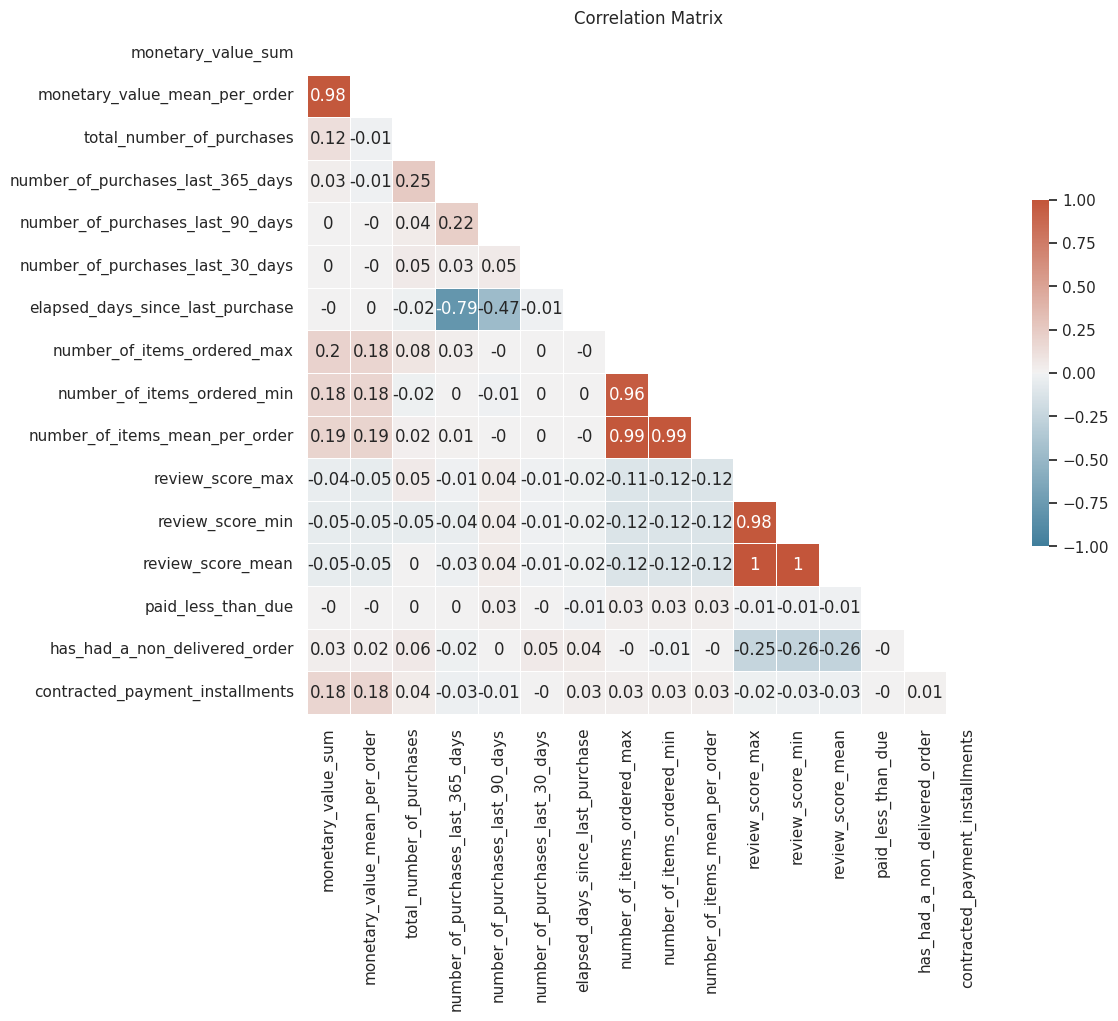

In [300]:
corr_input = (clients
              .dropna(axis=0)
              .drop('customer_unique_id', axis=1)
              .astype('float32'))

ds.display_correlation_matrix(corr_input)

## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>PCA

In [303]:
pca_input = clients.drop('customer_unique_id', axis=1)

scaler = StandardScaler()
clients_scaled = scaler.fit_transform(pca_input)
clients_scaled = pd.DataFrame(clients_scaled,
                              index=pca_input.index,
                              columns=pca_input.columns)
clients_scaled.head()

,monetary_value_sum,monetary_value_mean_per_order,total_number_of_purchases,number_of_purchases_last_365_days,number_of_purchases_last_90_days,number_of_purchases_last_30_days,elapsed_days_since_last_purchase,number_of_items_ordered_max,number_of_items_ordered_min,number_of_items_mean_per_order,review_score_max,review_score_min,review_score_mean,paid_less_than_due,has_had_a_non_delivered_order,contracted_payment_installments
0,-0.100783,-0.081202,-0.162368,0.561084,-0.331578,-0.009678,-0.832621,-0.265566,-0.257699,-0.264009,0.673483,0.684572,0.682021,-0.014428,-0.177558,0.967660
1,-0.604035,-0.601280,-0.162368,0.561084,-0.331578,-0.009678,-0.813067,-0.265566,-0.257699,-0.264009,-0.072520,-0.053436,-0.063327,-0.014428,-0.177558,-1.033421
2,-0.345060,-0.333647,-0.162368,-1.469493,-0.331578,-0.009678,1.937662,-0.265566,-0.257699,-0.264009,-0.818522,-0.791443,-0.808676,-0.014428,-0.177558,0.967660
3,-0.531954,-0.526788,-0.162368,-1.469493,-0.331578,-0.009678,0.529706,-0.265566,-0.257699,-0.264009,-0.072520,-0.053436,-0.063327,-0.014428,-0.177558,0.967660
4,0.140468,0.168114,-0.162368,0.561084,-0.331578,-0.009678,0.314602,-0.265566,-0.257699,-0.264009,0.673483,0.684572,0.682021,-0.014428,-0.177558,0.967660


array([[<AxesSubplot: title={'center': 'monetary_value_sum'}>,
        <AxesSubplot: title={'center': 'monetary_value_mean_per_order'}>,
        <AxesSubplot: title={'center': 'total_number_of_purchases'}>,
        <AxesSubplot: title={'center': 'number_of_purchases_last_365_days'}>],
       [<AxesSubplot: title={'center': 'number_of_purchases_last_90_days'}>,
        <AxesSubplot: title={'center': 'number_of_purchases_last_30_days'}>,
        <AxesSubplot: title={'center': 'elapsed_days_since_last_purchase'}>,
        <AxesSubplot: title={'center': 'number_of_items_ordered_max'}>],
       [<AxesSubplot: title={'center': 'number_of_items_ordered_min'}>,
        <AxesSubplot: title={'center': 'number_of_items_mean_per_order'}>,
        <AxesSubplot: title={'center': 'review_score_max'}>,
        <AxesSubplot: title={'center': 'review_score_min'}>],
       [<AxesSubplot: title={'center': 'review_score_mean'}>,
        <AxesSubplot: title={'center': 'paid_less_than_due'}>,
        <AxesSu

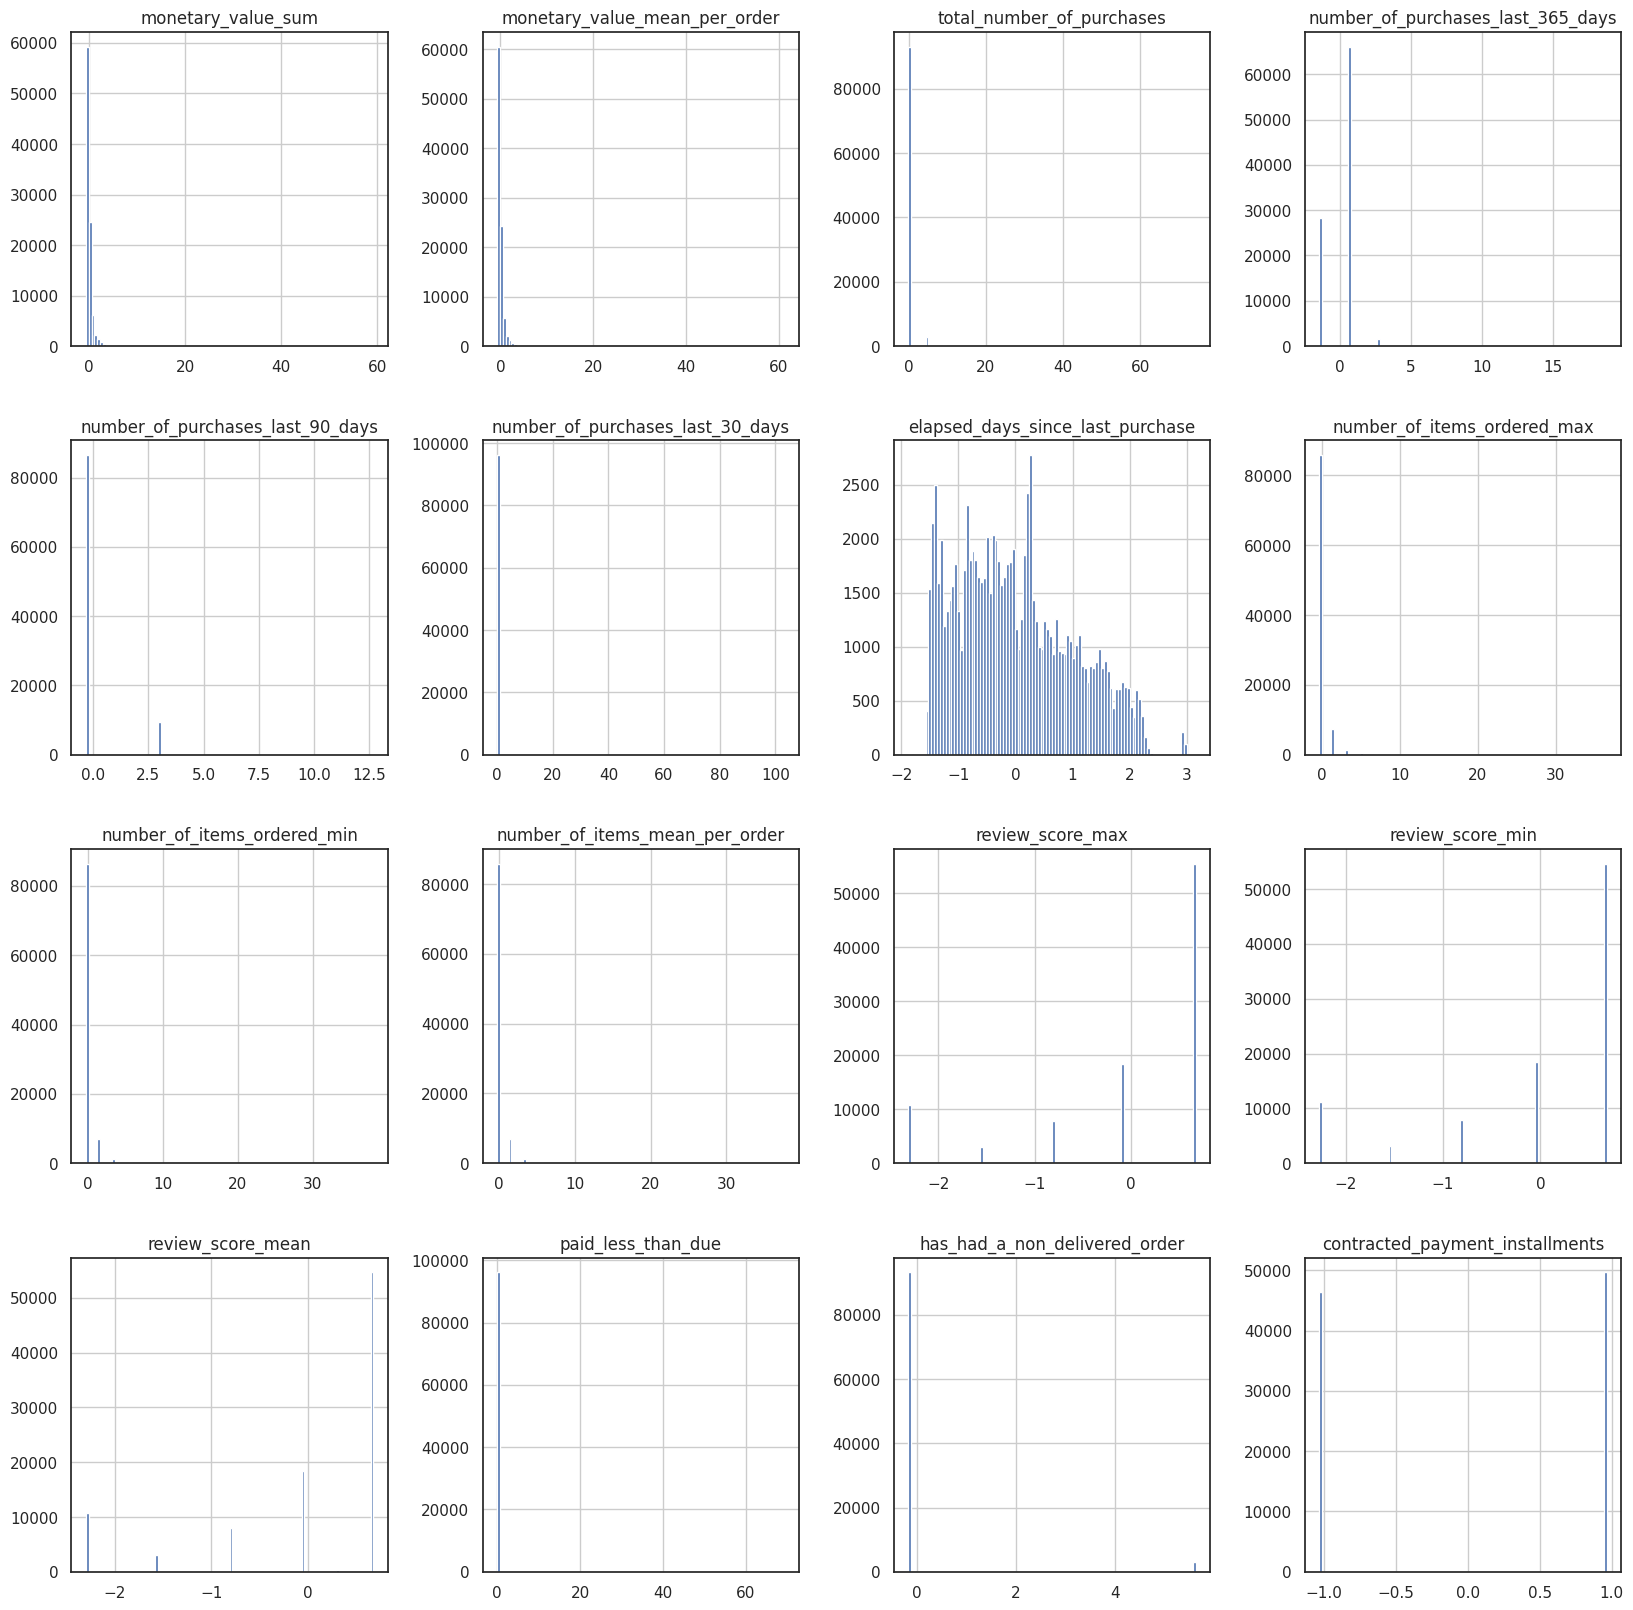

In [308]:
clients_scaled.hist(bins=100, figsize=(20,20))

In [309]:
clients_scaled.describe()

,monetary_value_sum,monetary_value_mean_per_order,total_number_of_purchases,number_of_purchases_last_365_days,number_of_purchases_last_90_days,number_of_purchases_last_30_days,elapsed_days_since_last_purchase,number_of_items_ordered_max,number_of_items_ordered_min,number_of_items_mean_per_order,review_score_max,review_score_min,review_score_mean,paid_less_than_due,has_had_a_non_delivered_order,contracted_payment_installments
count,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.609600e+04,9.542000e+04,9.542000e+04,9.542000e+04,9.538000e+04,9.538000e+04,9.538000e+04,9.609600e+04,9.609600e+04,9.609600e+04
mean,-3.741411e-17,-5.205441e-17,-4.356599e-16,4.887495e-17,-4.369909e-17,-6.580743e-18,1.254038e-16,-1.693329e-16,4.192366e-17,-1.383555e-16,1.778964e-16,3.329971e-17,-1.125634e-16,2.957637e-18,1.508395e-17,-5.893092e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-7.233218e-01,-7.245549e-01,-1.623683e-01,-1.469493e+00,-3.315784e-01,-9.678074e-03,-1.875552e+00,-2.655659e-01,-2.576993e-01,-2.640093e-01,-2.310527e+00,-2.267458e+00,-2.299373e+00,-1.442805e-02,-1.775577e-01,-1.033421e+00
25%,-4.496064e-01,-4.448619e-01,-1.623683e-01,-1.469493e+00,-3.315784e-01,-9.678074e-03,-8.130665e-01,-2.655659e-01,-2.576993e-01,-2.640093e-01,-7.251974e-02,-5.343552e-02,-6.332738e-02,-1.442805e-02,-1.775577e-01,-1.033421e+00
50%,-2.527103e-01,-2.476849e-01,-1.623683e-01,5.610836e-01,-3.315784e-01,-9.678074e-03,-1.286435e-01,-2.655659e-01,-2.576993e-01,-2.640093e-01,6.734825e-01,6.845721e-01,6.820211e-01,-1.442805e-02,-1.775577e-01,9.676597e-01
75%,7.618475e-02,7.444491e-02,-1.623683e-01,5.610836e-01,-3.315784e-01,-9.678074e-03,7.122192e-01,-2.655659e-01,-2.576993e-01,-2.640093e-01,6.734825e-01,6.845721e-01,6.820211e-01,-1.442805e-02,-1.775577e-01,9.676597e-01
max,5.922329e+01,6.122629e+01,7.447054e+01,1.883627e+01,1.268849e+01,1.033263e+02,3.156587e+00,3.658501e+01,3.807382e+01,3.769552e+01,6.734825e-01,6.845721e-01,6.820211e-01,6.930945e+01,5.631971e+00,9.676597e-01


In [311]:
pca = PCA()
clients_proj = pca.fit_transform(clients_scaled.dropna(axis=0))

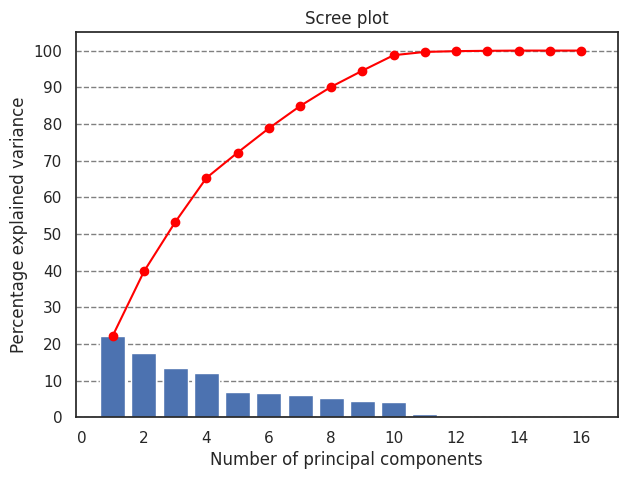

In [313]:
ds.display_scree_plot(pca)

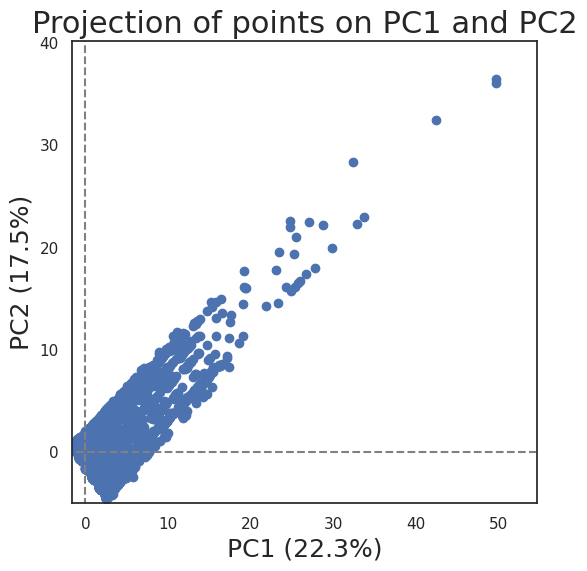

In [312]:
ds.display_factorial_plane_projection(clients_proj, pca, (0,1))

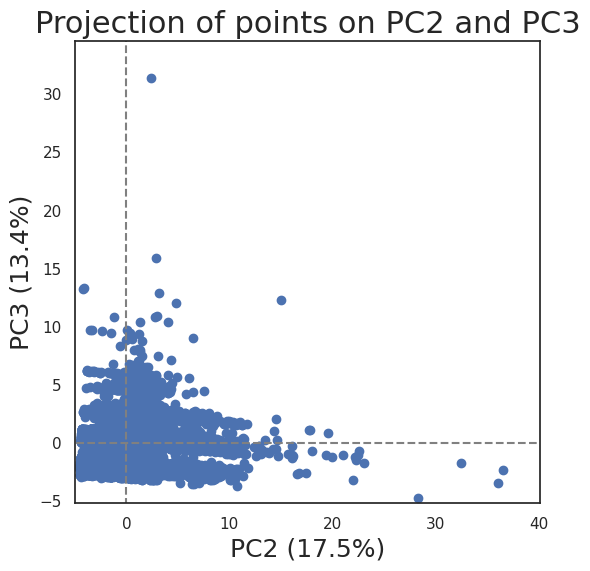

In [323]:
ds.display_factorial_plane_projection(clients_proj, pca, (1,2))


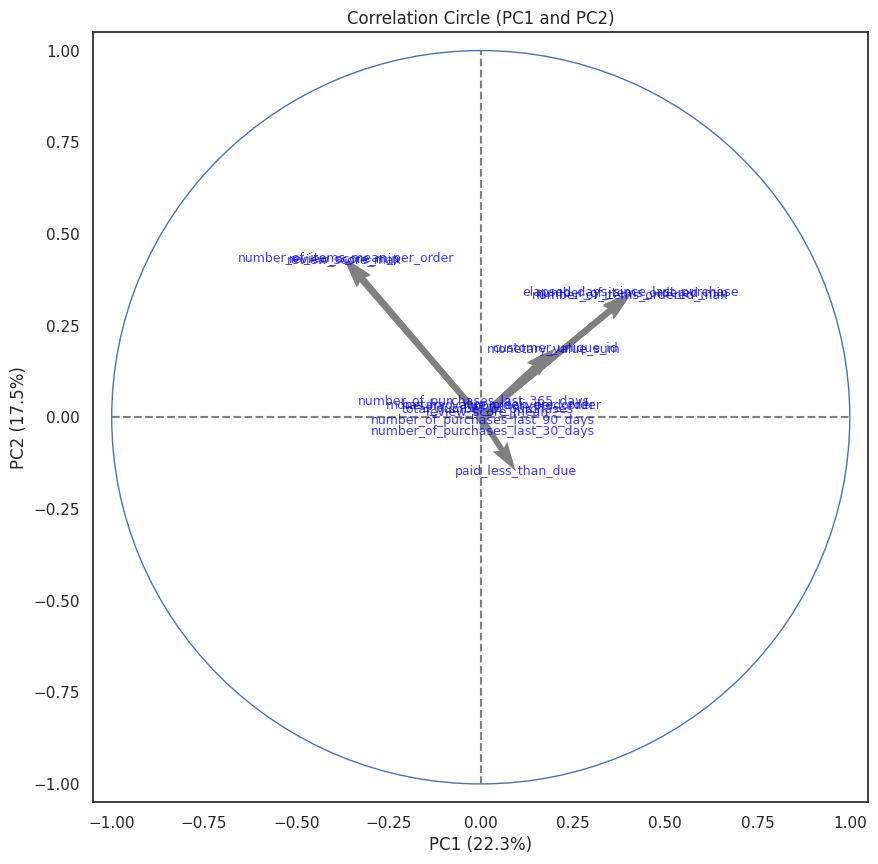

In [320]:
ds.display_correlation_circle(pca, (0,1), clients.columns)

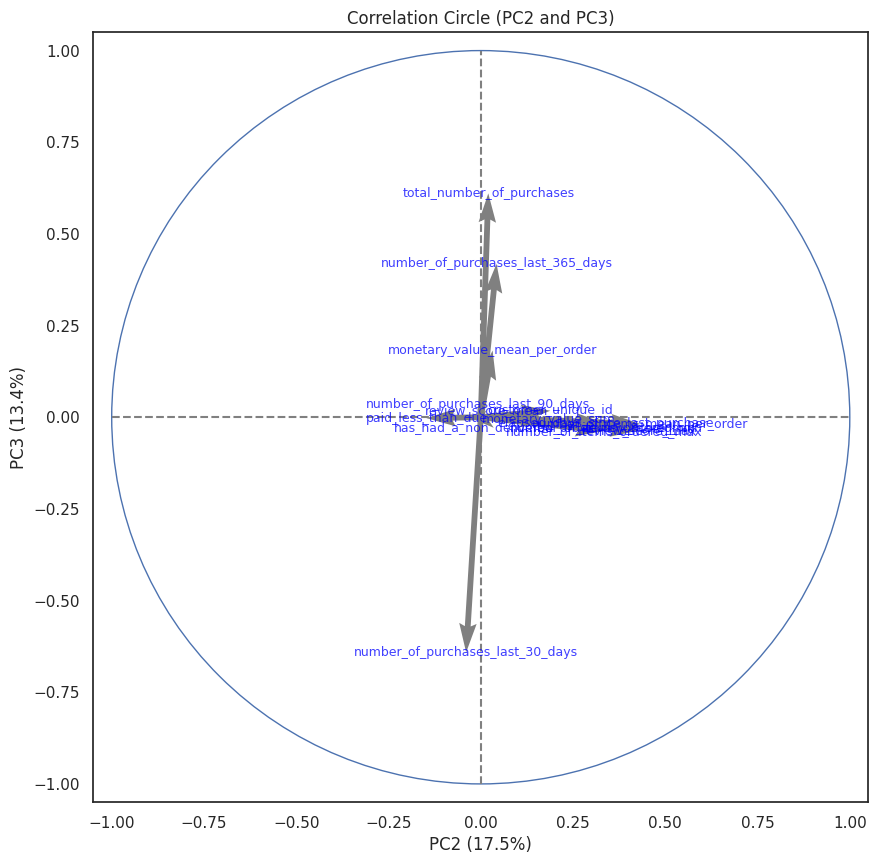

In [321]:
ds.display_correlation_circle(pca, (1,2), clients.columns)

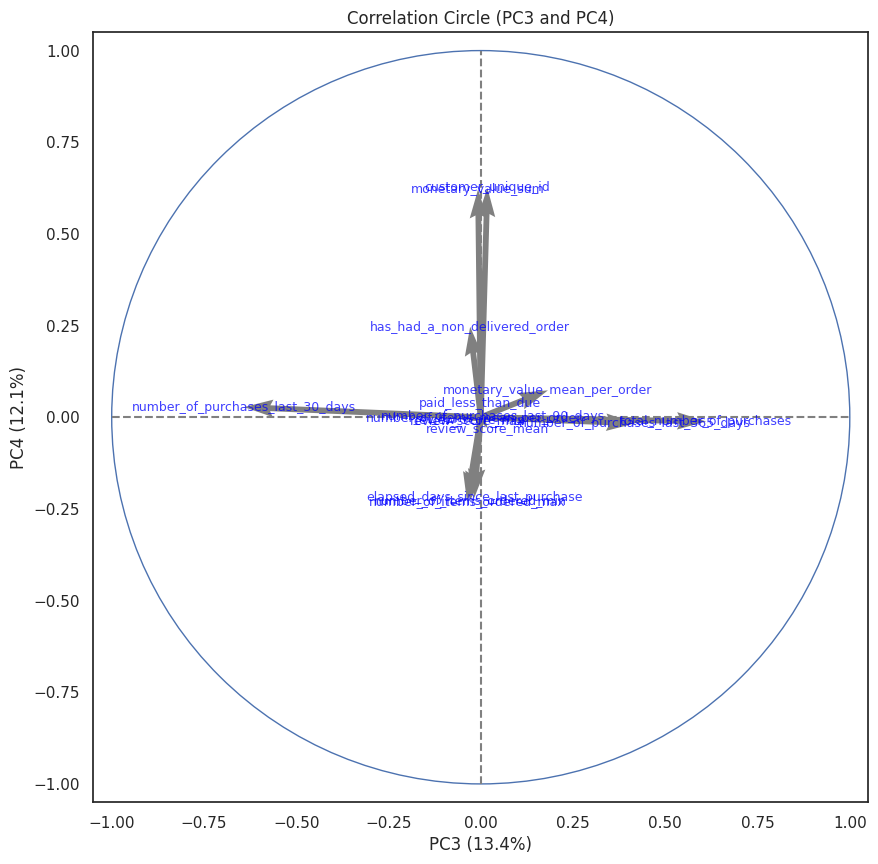

In [322]:
ds.display_correlation_circle(pca, (2,3), clients.columns)

# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Problematic order_ids